# Problem Statement

## Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).

## Objective

“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description

- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [1]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
    StackingClassifier
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
    classification_report
)

# To build model for statistical analysis and prediction
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns and rows to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

## Loading the dataset

In [2]:
# Giving Colab access to Drive
from google.colab import drive
drive.mount('/content/drive')

# Uploading the training and test dataset
data = pd.read_csv('/content/drive/My Drive/PG Data Science and Business Analysis/Project 6: ReneWind/Train.csv.csv')
data_test = pd.read_csv('/content/drive/My Drive/PG Data Science and Business Analysis/Project 6: ReneWind/Test.csv.csv')

Mounted at /content/drive


In [3]:
# Making a copy of the datasets to avoid changes to the original
df = data.copy()
df_test = data_test.copy()

## Data Overview

The initial steps to get an overview of the dataset is to:
- Observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- Get information about the number of rows and columns in the dataset
- Find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.
- Check the statistical summary of the dataset to get an overview of the numerical columns of the data
- Observations
- Sanity checks

### View the first 5 rows of the datasets

In [4]:
# View the first 5 rows of the training set
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [5]:
# View the last 5 rows of the test set
df_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-0.613,-3.820,2.202,1.300,-1.185,-4.496,-1.836,4.723,1.206,-0.342,-5.123,1.017,4.819,3.269,-2.984,1.387,2.032,-0.512,-1.023,7.339,-2.242,0.155,2.054,-2.772,1.851,-1.789,-0.277,-1.255,-3.833,-1.505,1.587,2.291,-5.411,0.870,0.574,4.157,1.428,-10.511,0.455,-1.448,0
1,0.390,-0.512,0.527,-2.577,-1.017,2.235,-0.441,-4.406,-0.333,1.967,1.797,0.410,0.638,-1.390,-1.883,-5.018,-3.827,2.418,1.762,-3.242,-3.193,1.857,-1.708,0.633,-0.588,0.084,3.014,-0.182,0.224,0.865,-1.782,-2.475,2.494,0.315,2.059,0.684,-0.485,5.128,1.721,-1.488,0
2,-0.875,-0.641,4.084,-1.590,0.526,-1.958,-0.695,1.347,-1.732,0.466,-4.928,3.565,-0.449,-0.656,-0.167,-1.630,2.292,2.396,0.601,1.794,-2.120,0.482,-0.841,1.790,1.874,0.364,-0.169,-0.484,-2.119,-2.157,2.907,-1.319,-2.997,0.460,0.620,5.632,1.324,-1.752,1.808,1.676,0
3,0.238,1.459,4.015,2.534,1.197,-3.117,-0.924,0.269,1.322,0.702,-5.578,-0.851,2.591,0.767,-2.391,-2.342,0.572,-0.934,0.509,1.211,-3.260,0.105,-0.659,1.498,1.100,4.143,-0.248,-1.137,-5.356,-4.546,3.809,3.518,-3.074,-0.284,0.955,3.029,-1.367,-3.412,0.906,-2.451,0
4,5.828,2.768,-1.235,2.809,-1.642,-1.407,0.569,0.965,1.918,-2.775,-0.530,1.375,-0.651,-1.679,-0.379,-4.443,3.894,-0.608,2.945,0.367,-5.789,4.598,4.450,3.225,0.397,0.248,-2.362,1.079,-0.473,2.243,-3.591,1.774,-1.502,-2.227,4.777,-6.560,-0.806,-0.276,-3.858,-0.538,0


* The dataset has been loaded properly.
* The columns correspond with different sensors for wind, humidity, gearbox, tower, etc. There are a total of 40 sensors.
* The last column corresponds to the target variable to decide if the sensor is considered a failure (1) or not a failure (0).
* Each row corresponds to a different generator.

### Checking the shape of the datasets

In [6]:
# Shape of training set
df.shape

(20000, 41)

In [7]:
# Shape of test set
df_test.shape

(5000, 41)

* Training set consists on 20000 rows and 41 columns.
* Test set has 5000 rows and 41 columns.

### Looking at the datatypes of each column

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

* All columns are of numerical type.
* Predictor columns are float types and target variable is of integer type.
* There seems to be some missing values in the data.

### Checking for missing and duplicated values

In [10]:
# Checking for missing values in training set
df.isnull().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

In [11]:
# Checking for missing values in test set
df_test.isnull().sum()

V1        5
V2        6
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
V29       0
V30       0
V31       0
V32       0
V33       0
V34       0
V35       0
V36       0
V37       0
V38       0
V39       0
V40       0
Target    0
dtype: int64

In [12]:
# Checking for duplicated values in train set
df.duplicated().sum()

0

In [13]:
# Checking for duplicates in test set
df.duplicated().sum()

0

* There are missing values in both datasets for columns V1 and V2.
* There are no duplicated values.

### Checking the statistical summary of all columns

In [14]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,19982.000,19982.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000
mean,-0.272,0.440,2.485,-0.083,-0.054,-0.995,-0.879,-0.548,-0.017,-0.013,-1.895,1.605,1.580,-0.951,-2.415,-2.925,-0.134,1.189,1.182,0.024,-3.611,0.952,-0.366,1.134,-0.002,1.874,-0.612,-0.883,-0.986,-0.016,0.487,0.304,0.050,-0.463,2.230,1.515,0.011,-0.344,0.891,-0.876,0.056
std,3.442,3.151,3.389,3.432,2.105,2.041,1.762,3.296,2.161,2.193,3.124,2.930,2.875,1.790,3.355,4.222,3.345,2.592,3.397,3.669,3.568,1.652,4.032,3.912,2.017,3.435,4.369,1.918,2.684,3.005,3.461,5.500,3.575,3.184,2.937,3.801,1.788,3.948,1.753,3.012,0.229
min,-11.876,-12.320,-10.708,-15.082,-8.603,-10.227,-7.950,-15.658,-8.596,-9.854,-14.832,-12.948,-13.228,-7.739,-16.417,-20.374,-14.091,-11.644,-13.492,-13.923,-17.956,-10.122,-14.866,-16.387,-8.228,-11.834,-14.905,-9.269,-12.579,-14.796,-13.723,-19.877,-16.898,-17.985,-15.350,-14.833,-5.478,-17.375,-6.439,-11.024,0.000
25%,-2.737,-1.641,0.207,-2.348,-1.536,-2.347,-2.031,-2.643,-1.495,-1.411,-3.922,-0.397,-0.224,-2.171,-4.415,-5.634,-2.216,-0.404,-1.050,-2.433,-5.930,-0.118,-3.099,-1.468,-1.365,-0.338,-3.652,-2.171,-2.787,-1.867,-1.818,-3.420,-2.243,-2.137,0.336,-0.944,-1.256,-2.988,-0.272,-2.940,0.000
50%,-0.748,0.472,2.256,-0.135,-0.102,-1.001,-0.917,-0.389,-0.068,0.101,-1.921,1.508,1.637,-0.957,-2.383,-2.683,-0.015,0.883,1.279,0.033,-3.533,0.975,-0.262,0.969,0.025,1.951,-0.885,-0.891,-1.176,0.184,0.490,0.052,-0.066,-0.255,2.099,1.567,-0.128,-0.317,0.919,-0.921,0.000
75%,1.840,2.544,4.566,2.131,1.340,0.380,0.224,1.723,1.409,1.477,0.119,3.571,3.460,0.271,-0.359,-0.095,2.069,2.572,3.493,2.512,-1.266,2.026,2.452,3.546,1.397,4.130,2.189,0.376,0.630,2.036,2.731,3.762,2.255,1.437,4.064,3.984,1.176,2.279,2.058,1.120,0.000
max,15.493,13.089,17.091,13.236,8.134,6.976,8.006,11.679,8.138,8.108,11.826,15.081,15.420,5.671,12.246,13.583,16.756,13.180,13.238,16.052,13.840,7.410,14.459,17.163,8.223,16.836,17.560,6.528,10.722,12.506,17.255,23.633,16.692,14.358,15.291,19.330,7.467,15.290,7.760,10.654,1.000


In [15]:
df_test.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,4995.000,4994.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000,5000.000
mean,-0.278,0.398,2.552,-0.049,-0.080,-1.042,-0.908,-0.575,0.030,0.019,-2.009,1.576,1.622,-0.921,-2.452,-3.019,-0.104,1.196,1.210,0.138,-3.664,0.962,-0.422,1.089,0.061,1.847,-0.552,-0.868,-1.096,-0.119,0.469,0.233,-0.080,-0.393,2.211,1.595,0.023,-0.406,0.939,-0.932,0.056
std,3.466,3.140,3.327,3.414,2.111,2.005,1.769,3.332,2.174,2.145,3.112,2.907,2.883,1.803,3.387,4.264,3.337,2.586,3.385,3.657,3.578,1.640,4.057,3.968,2.010,3.400,4.403,1.926,2.655,3.023,3.446,5.586,3.539,3.166,2.948,3.775,1.785,3.969,1.717,2.978,0.231
min,-12.382,-10.716,-9.238,-14.682,-7.712,-8.924,-8.124,-12.253,-6.785,-8.171,-13.152,-8.164,-11.548,-7.814,-15.286,-20.986,-13.418,-12.214,-14.170,-13.720,-16.341,-6.740,-14.422,-12.316,-6.770,-11.414,-13.177,-7.933,-9.988,-12.438,-11.263,-17.244,-14.904,-14.700,-12.261,-12.736,-5.079,-15.335,-5.451,-10.076,0.000
25%,-2.744,-1.649,0.315,-2.293,-1.615,-2.369,-2.054,-2.642,-1.456,-1.353,-4.050,-0.450,-0.126,-2.111,-4.479,-5.648,-2.228,-0.409,-1.026,-2.325,-5.944,-0.048,-3.163,-1.623,-1.298,-0.242,-3.663,-2.160,-2.861,-1.997,-1.822,-3.556,-2.348,-2.010,0.322,-0.866,-1.241,-2.984,-0.208,-2.987,0.000
50%,-0.765,0.427,2.260,-0.146,-0.132,-1.049,-0.940,-0.358,-0.080,0.166,-2.043,1.488,1.719,-0.896,-2.417,-2.774,0.047,0.881,1.296,0.193,-3.663,0.986,-0.279,0.913,0.077,1.917,-0.872,-0.931,-1.341,0.112,0.486,-0.077,-0.160,-0.172,2.112,1.703,-0.110,-0.381,0.959,-1.003,0.000
75%,1.831,2.444,4.587,2.166,1.341,0.308,0.212,1.713,1.450,1.511,0.044,3.563,3.465,0.272,-0.433,-0.178,2.112,2.604,3.526,2.540,-1.330,2.029,2.426,3.537,1.428,4.156,2.247,0.421,0.522,1.946,2.779,3.752,2.099,1.465,4.032,4.104,1.238,2.288,2.131,1.080,0.000
max,13.504,14.079,15.315,12.140,7.673,5.068,7.616,10.415,8.851,6.599,9.956,12.984,12.620,5.734,11.673,13.976,19.777,13.642,12.428,13.871,11.047,7.505,13.181,17.806,6.557,17.528,17.290,7.416,14.039,10.315,12.559,26.539,13.324,12.146,13.489,17.116,6.810,13.065,7.182,8.698,1.000


* All variables expect for Target have negative values. We can consider them true values as it's information about the sensors.
* Target column has a mean close to 0, the third quartile is also 0. We can assume that most of the sensors are not failing.
* V15, V16, and V21 have negative values up to the 3rd quartile.
* V32 has the highest standard deviation with 5.5.
* V22 has the lowest standard deviation at 1.652.
* The mean and median of most variables are close together, we can assume a symmetrical distribution across the variables.

## Exploratory Data Analysis (EDA)

* We will only perform EDA on the training dataset as the test dataset is unseen data that will be used to check performance of the final model.

### Creating a function to plot histograms and boxplots for all the variables

In [16]:
# function to plot a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Plotting all the features at one go

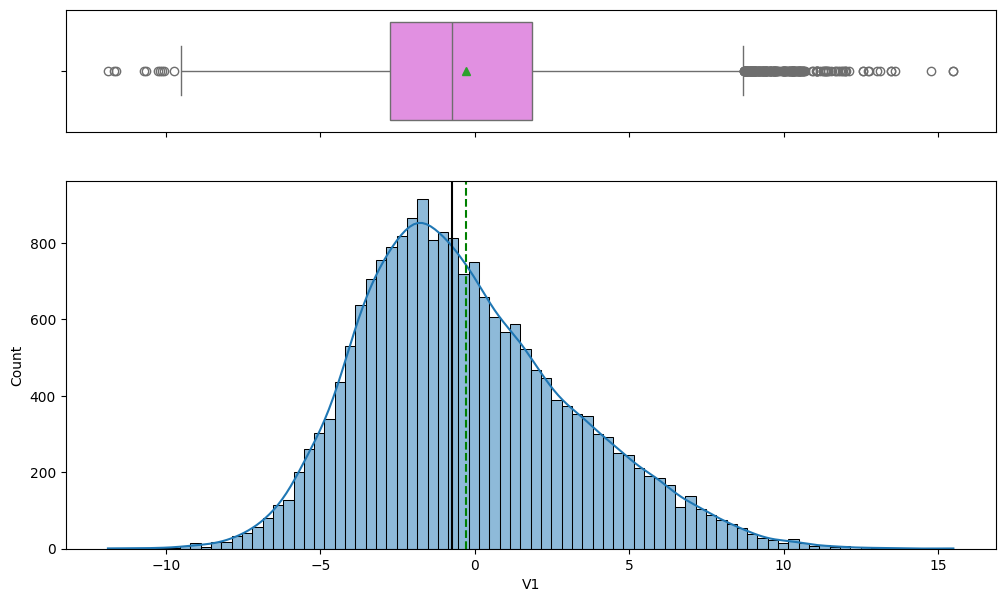

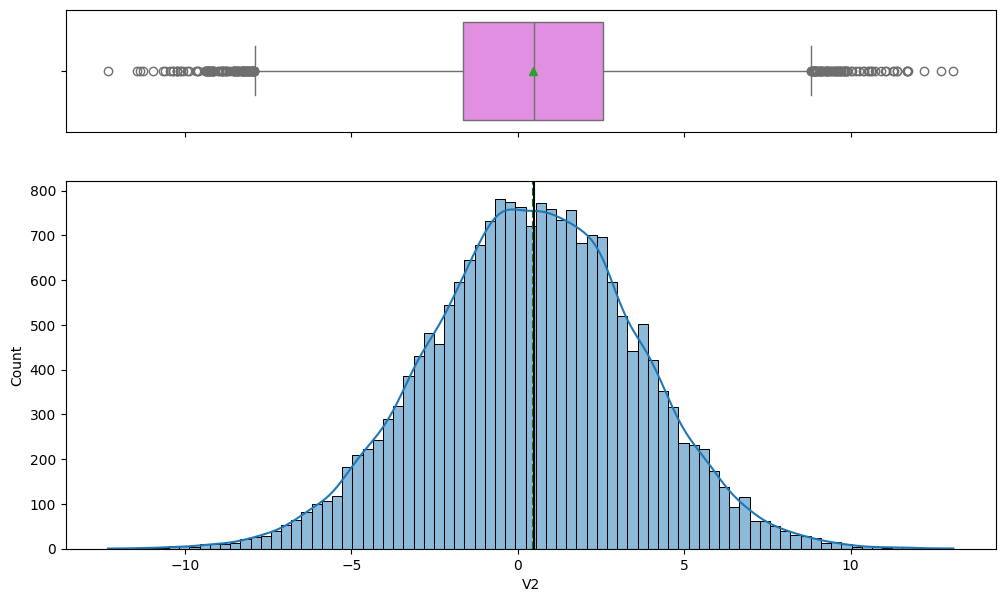

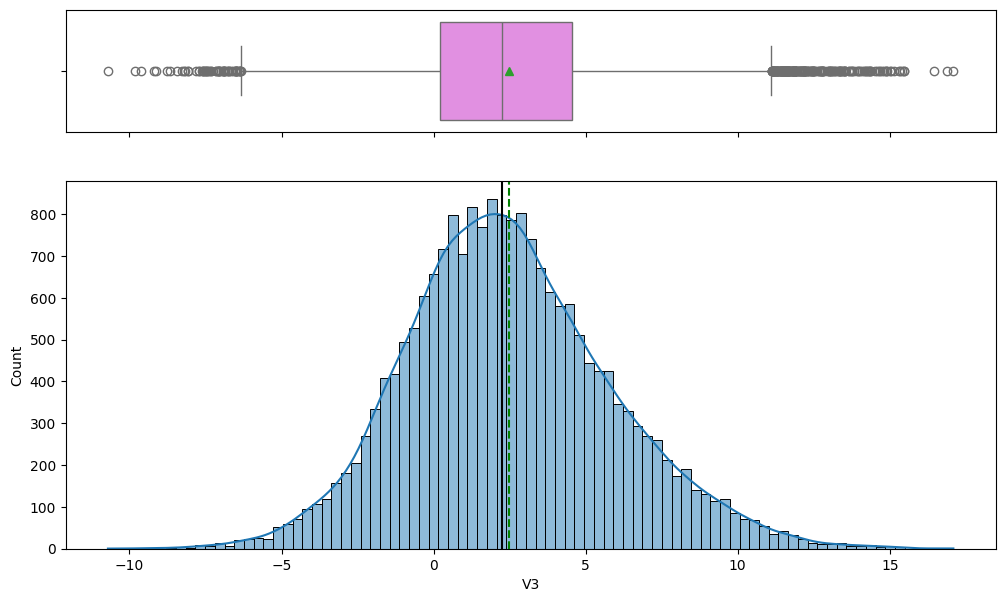

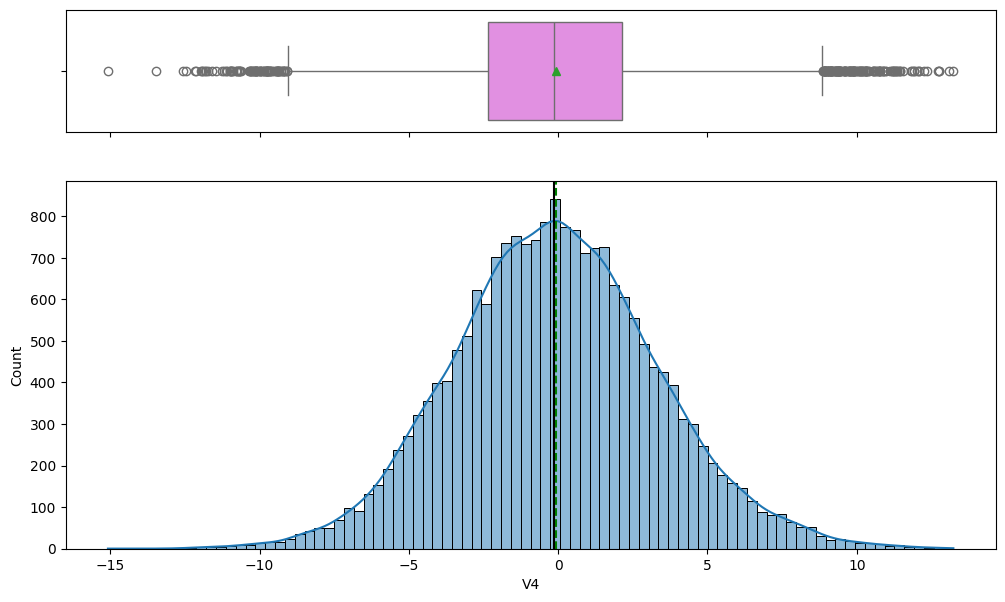

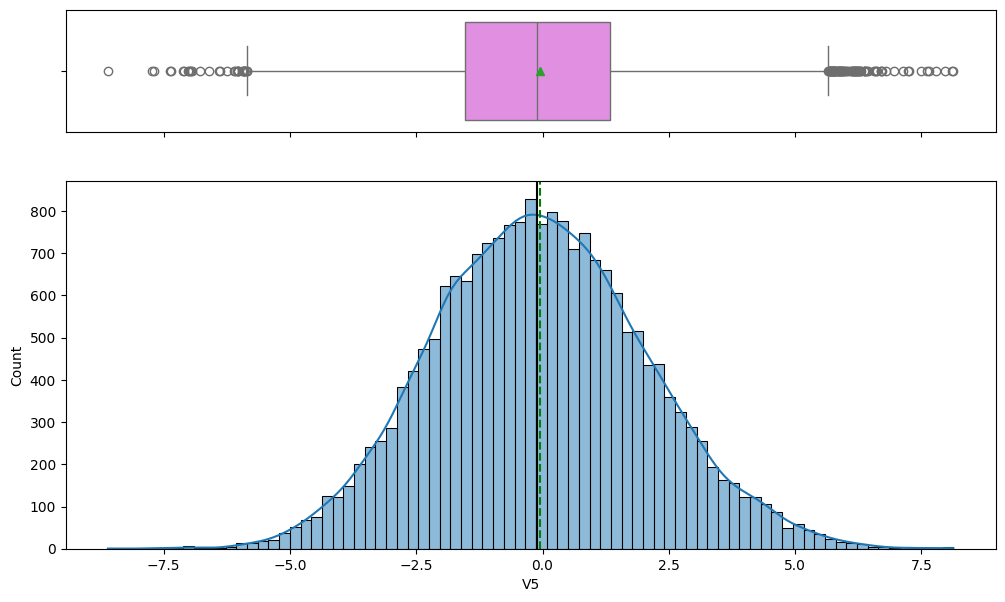

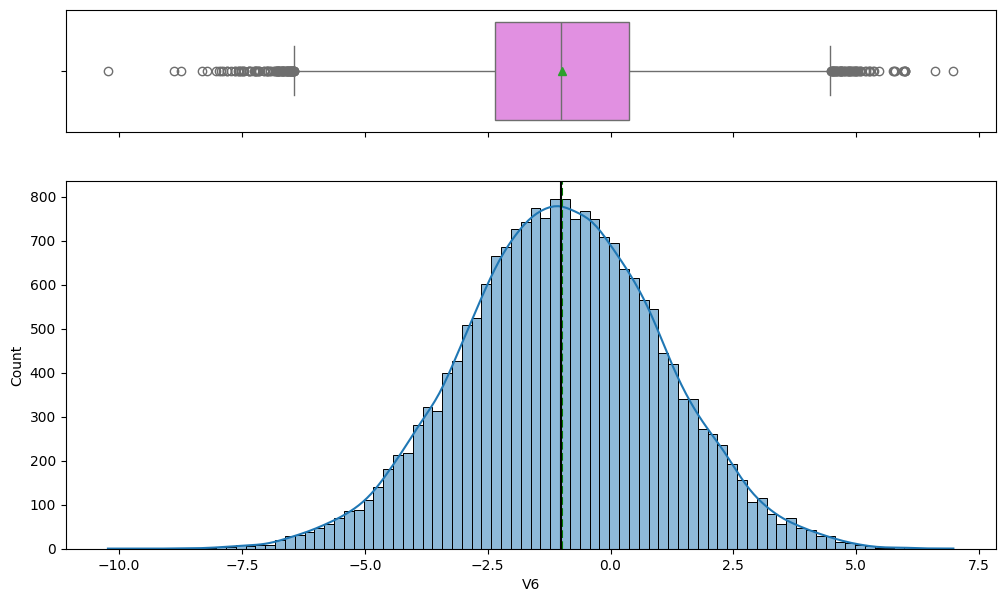

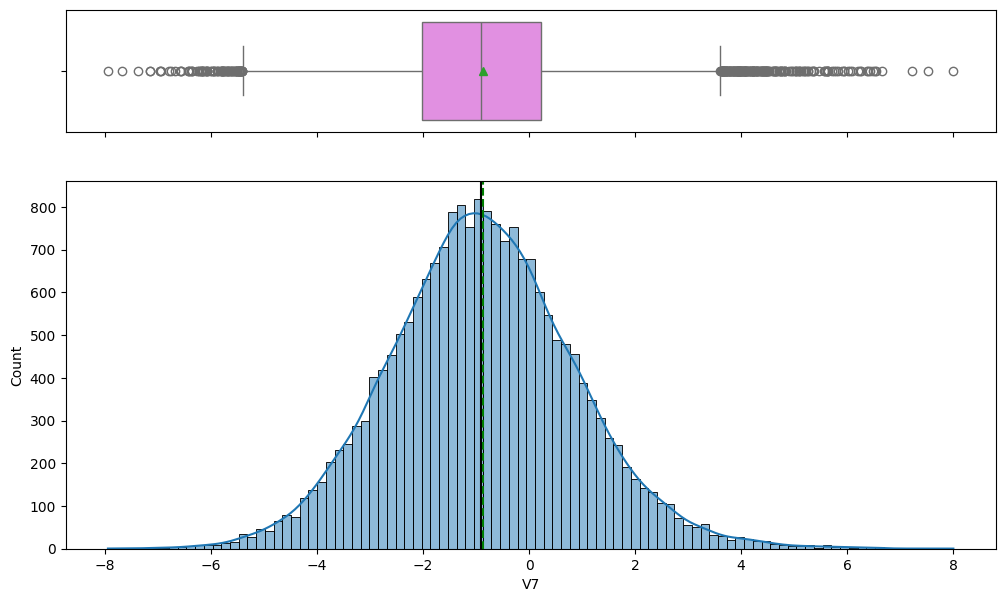

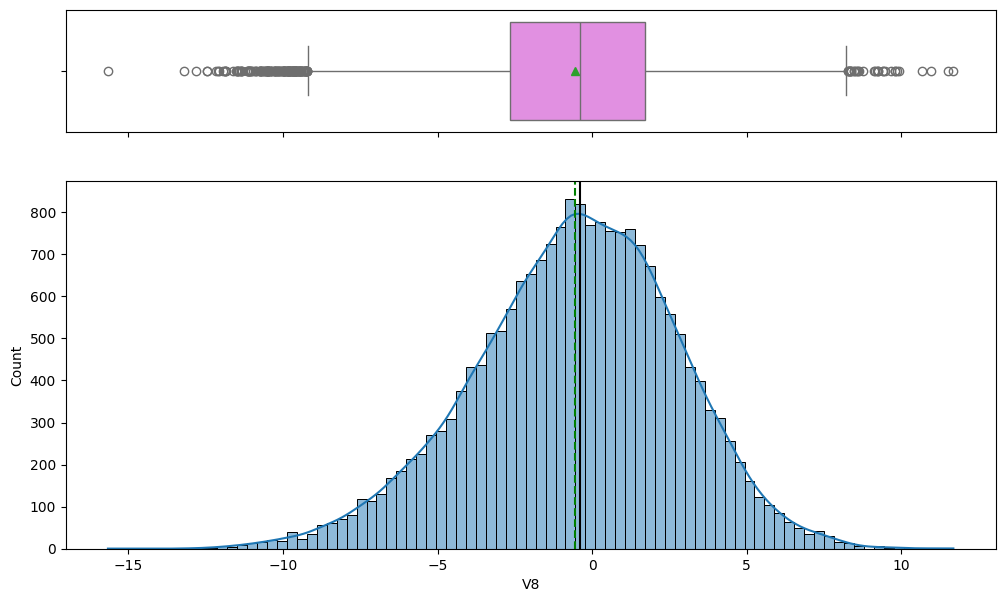

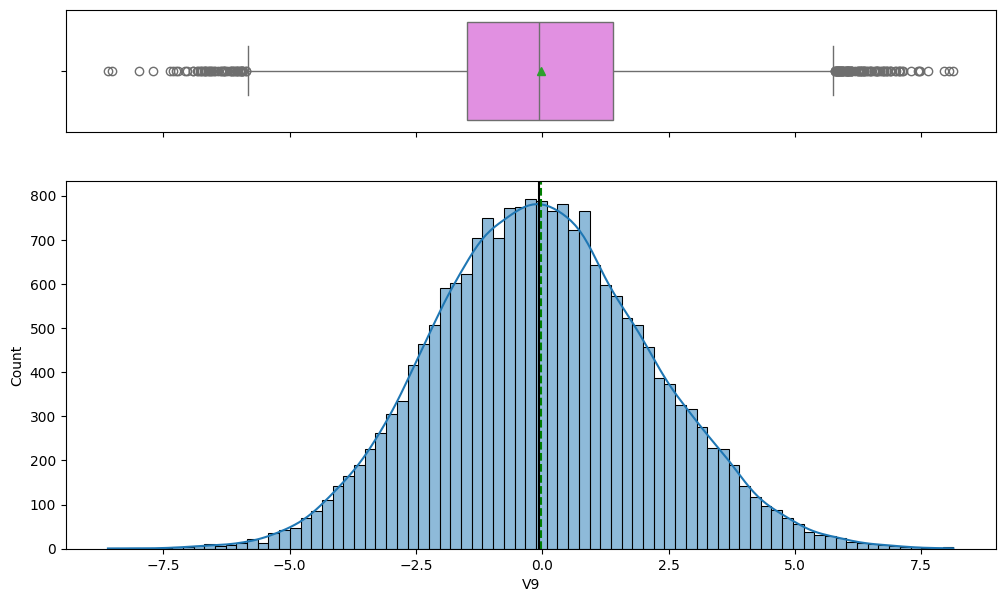

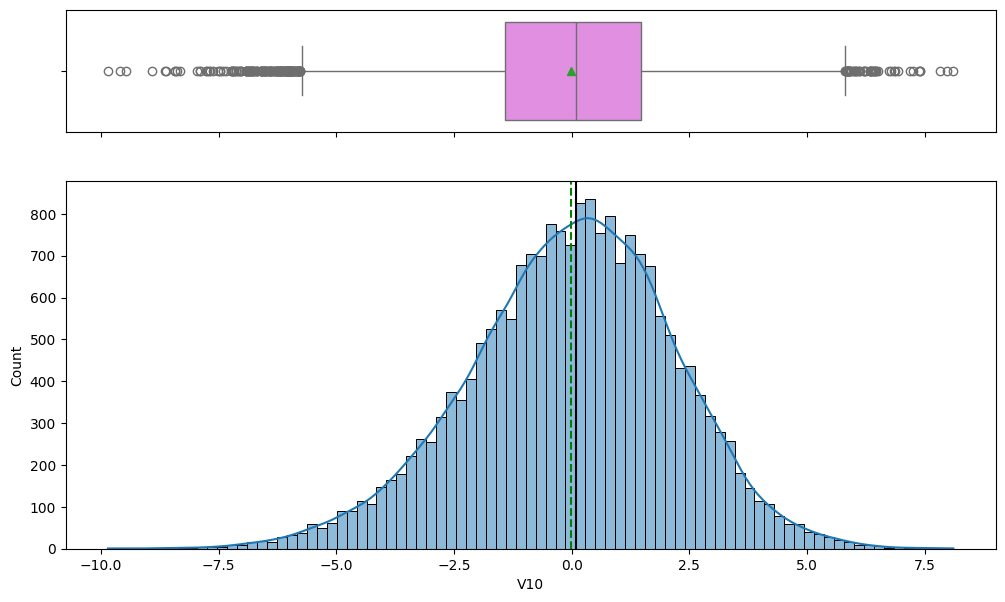

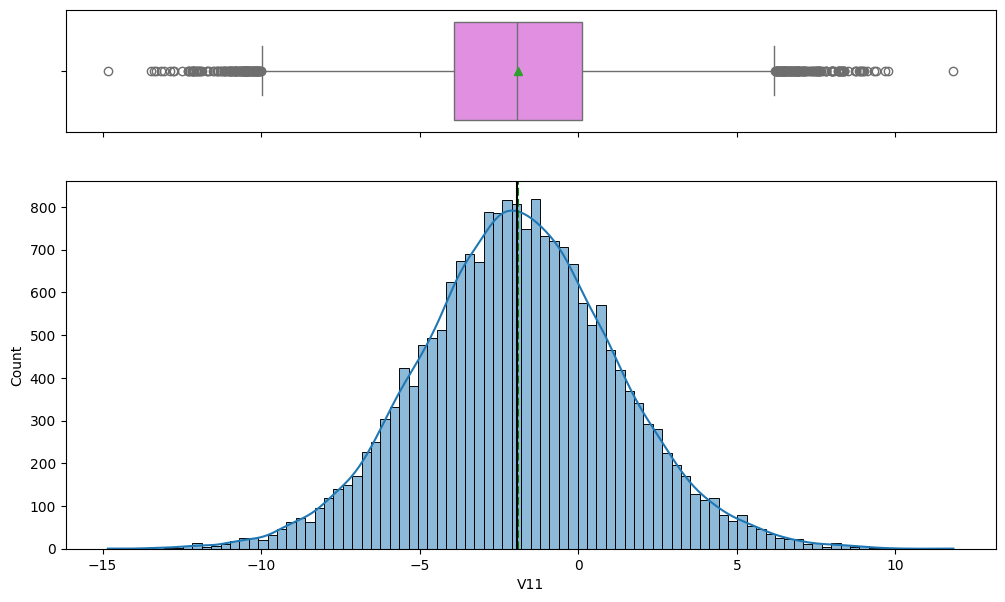

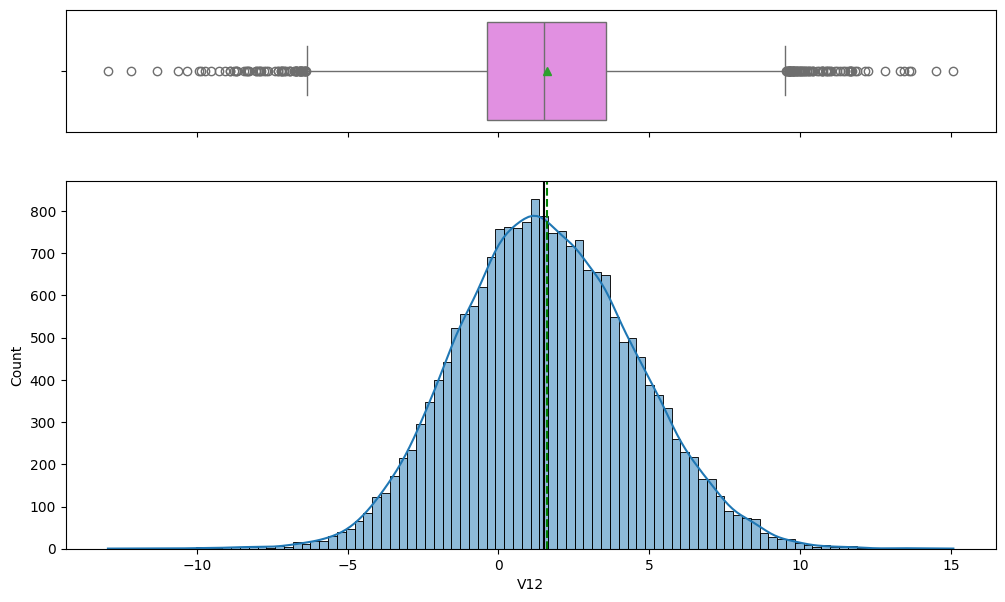

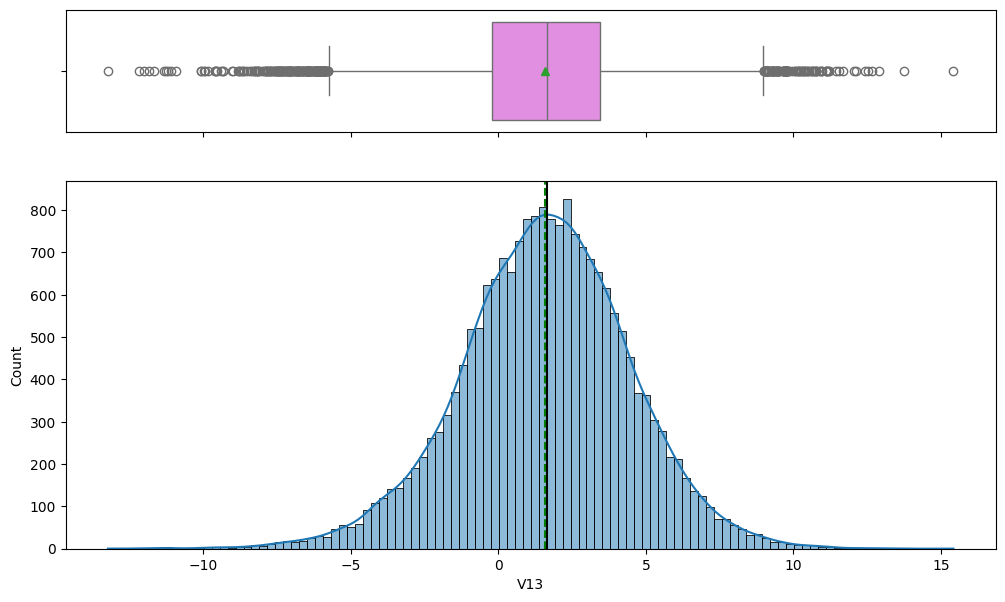

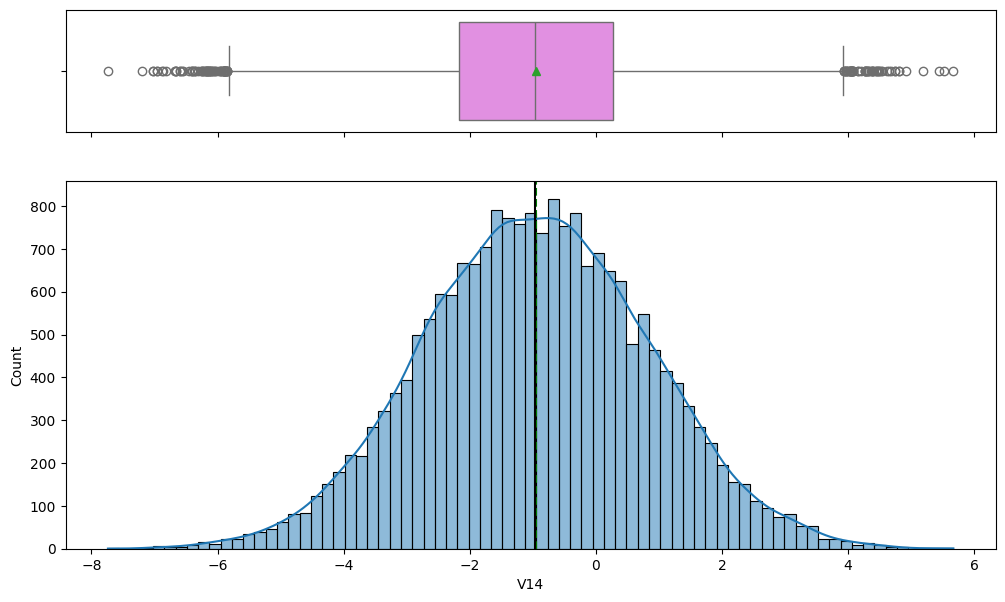

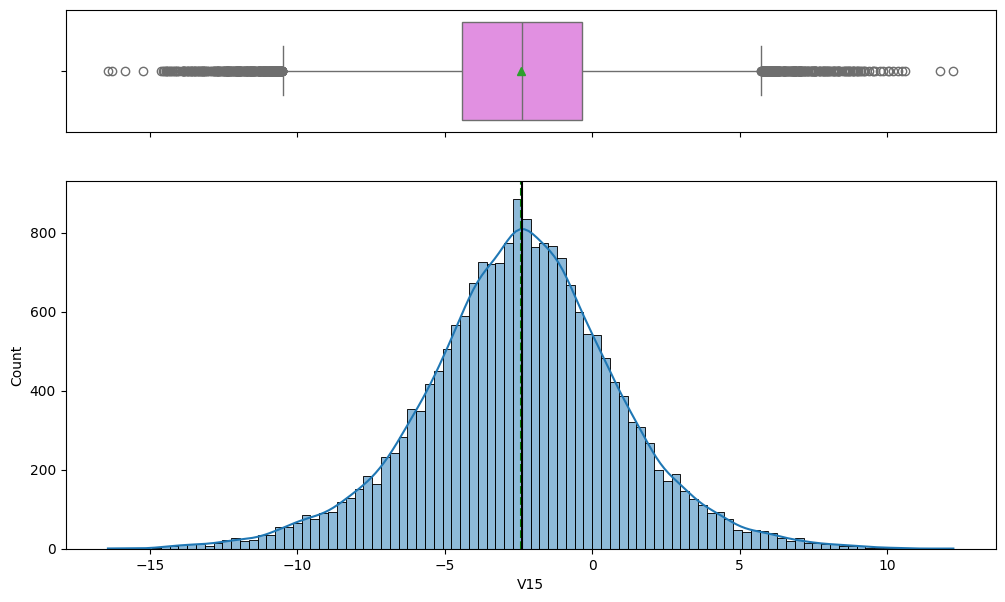

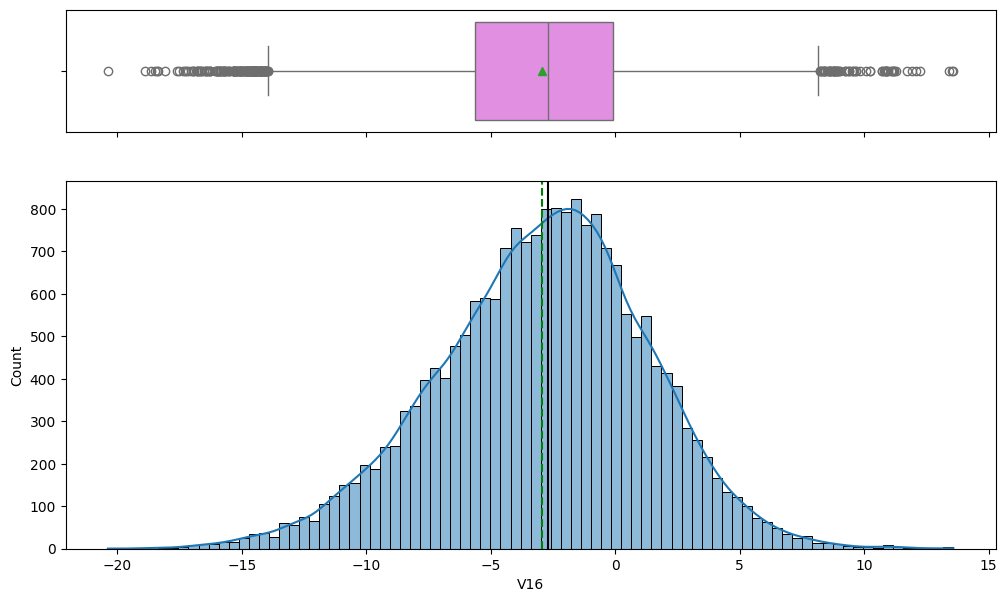

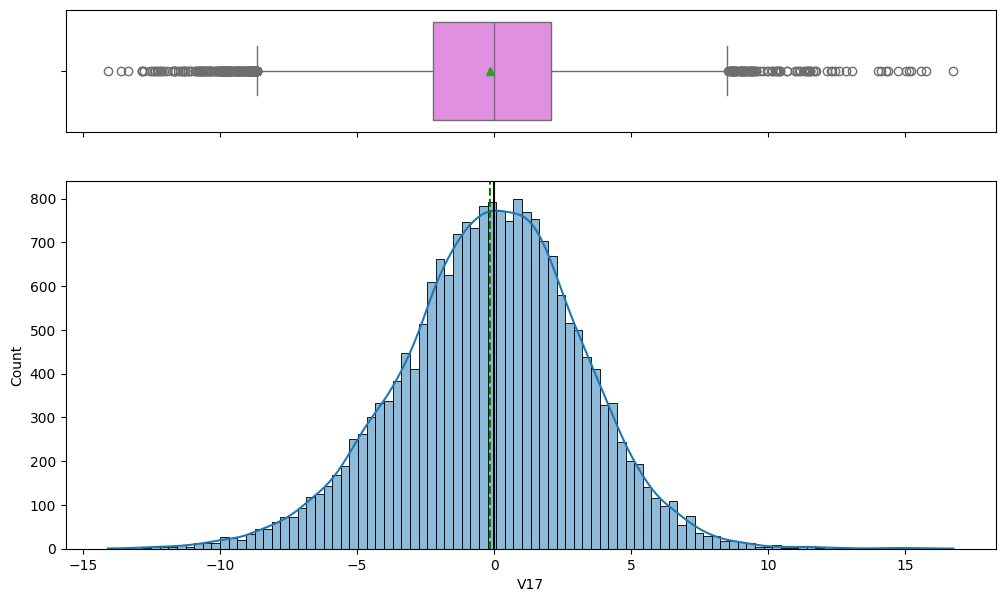

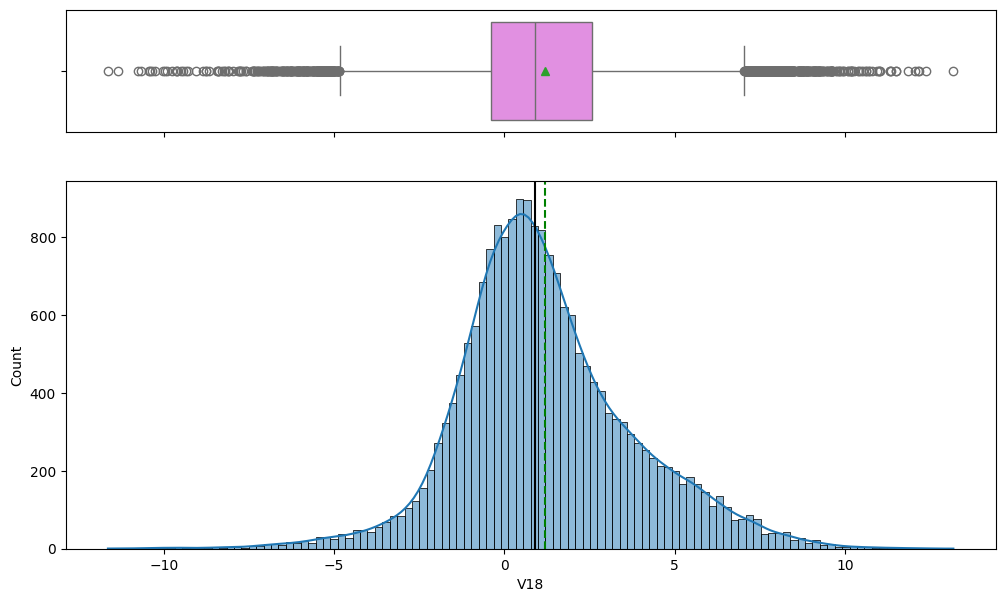

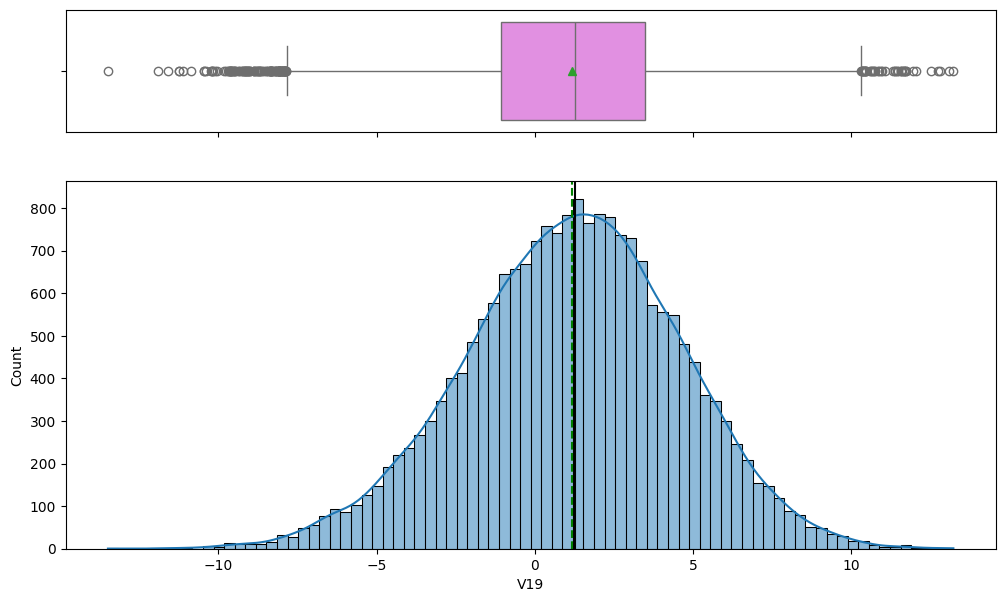

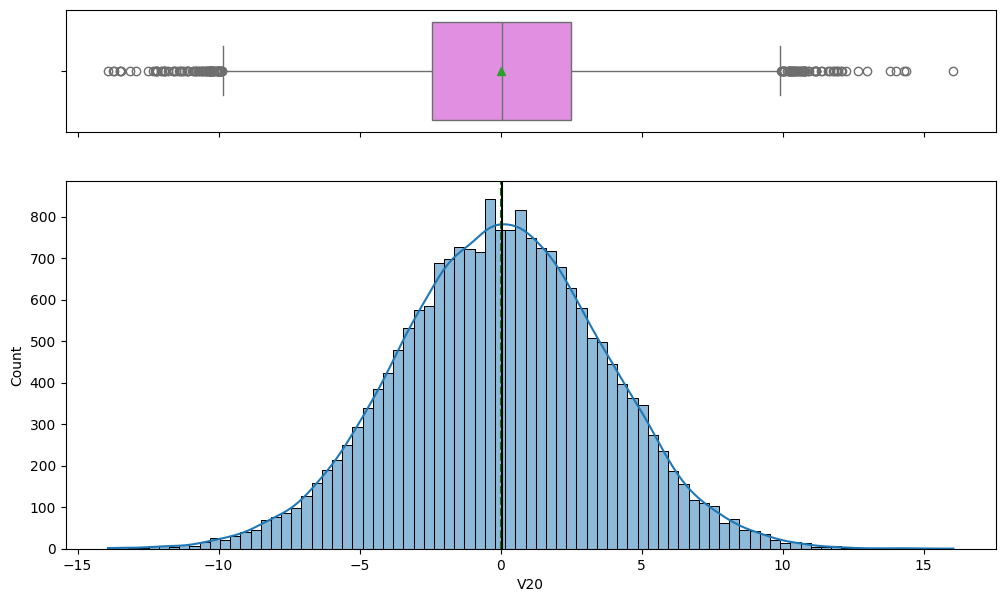

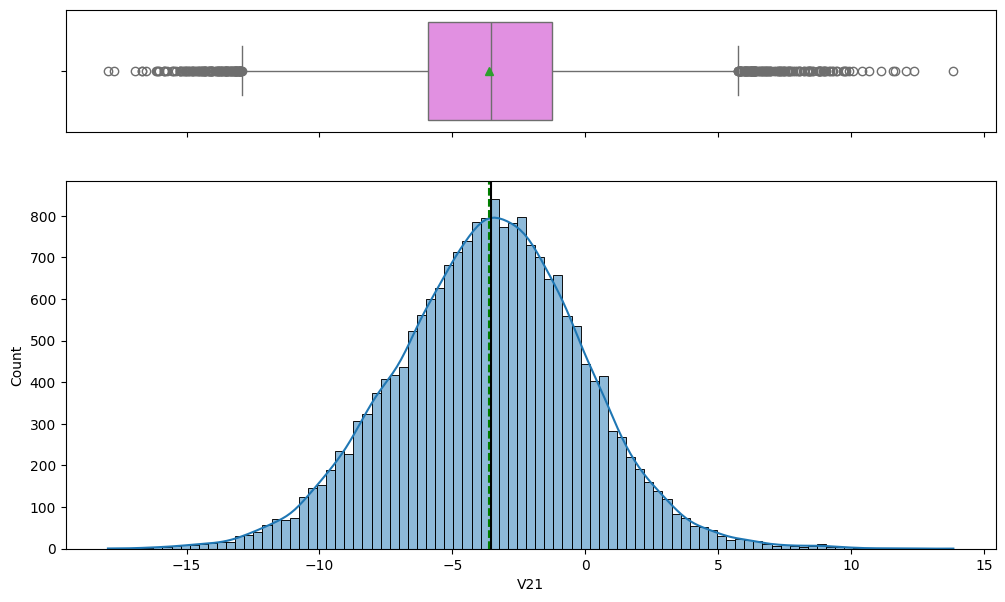

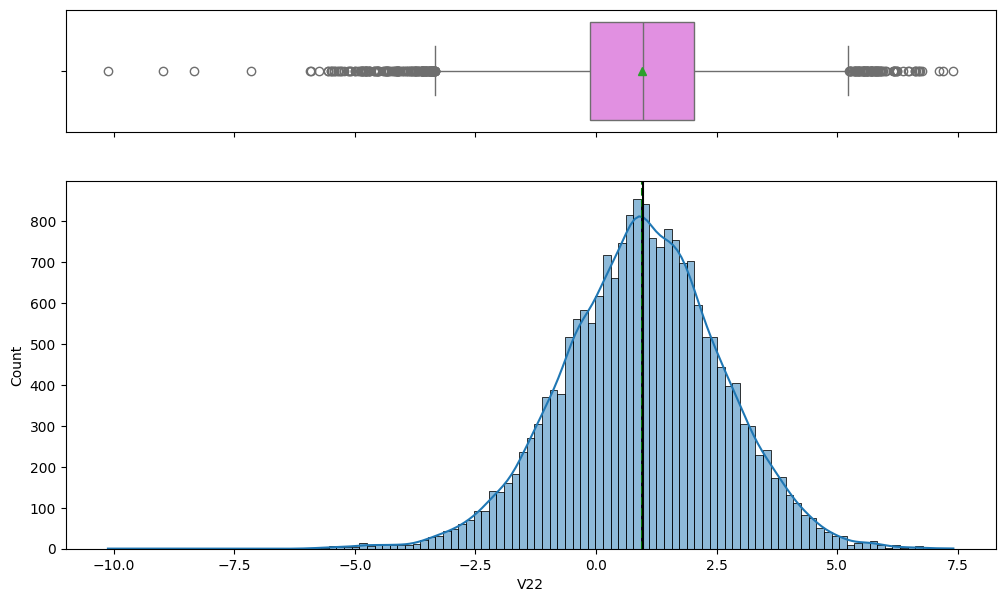

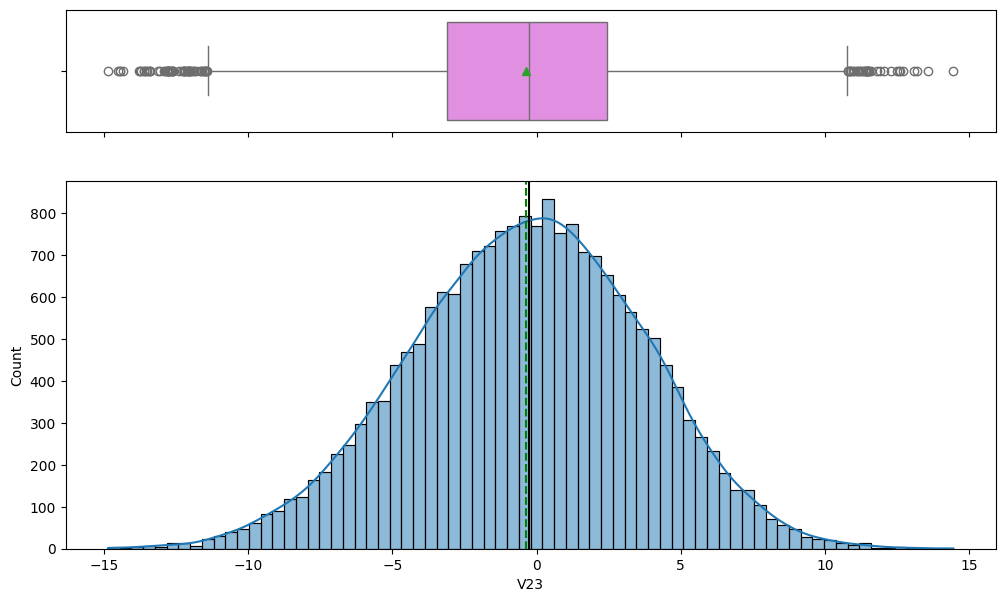

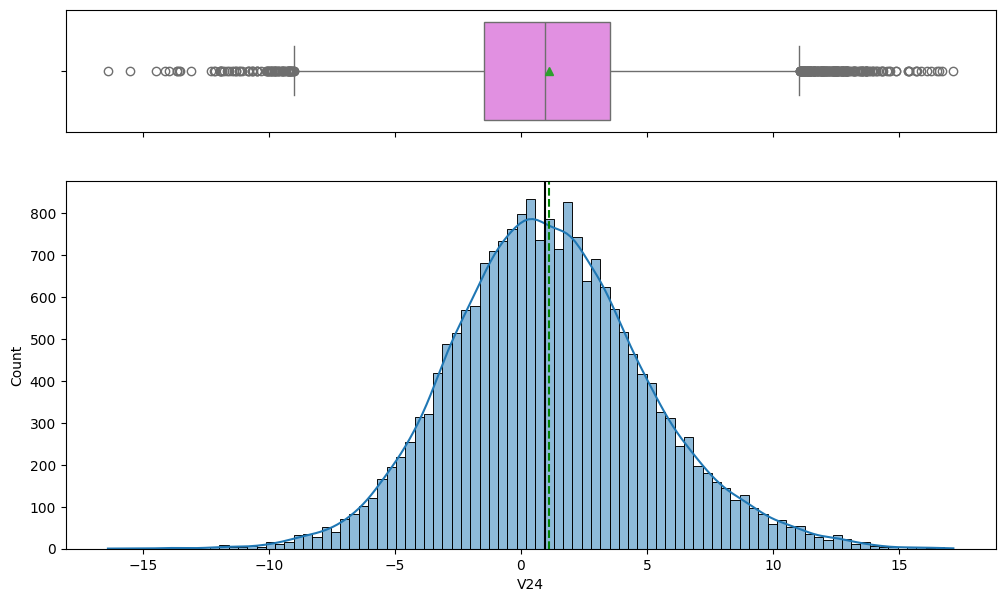

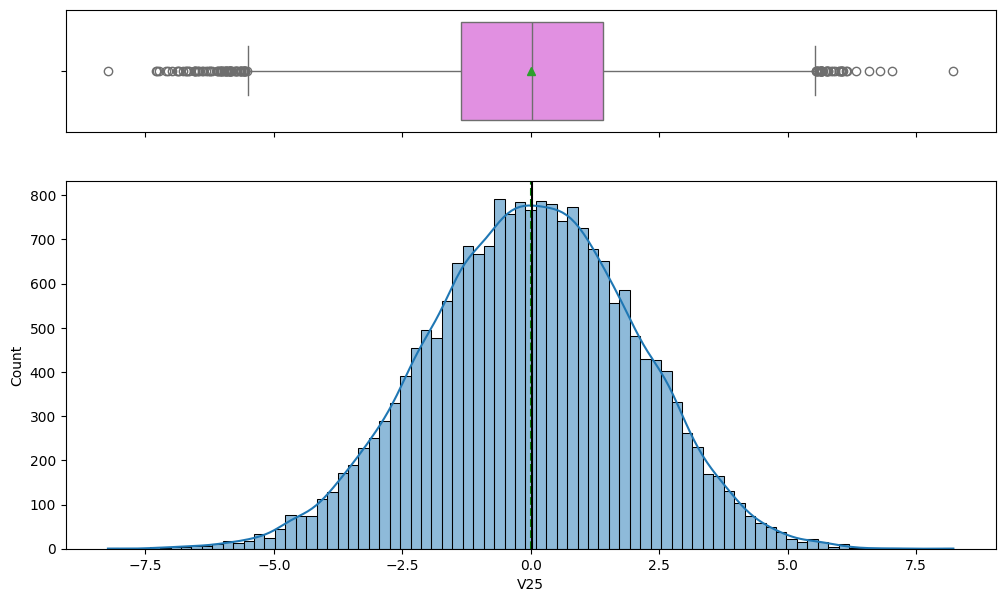

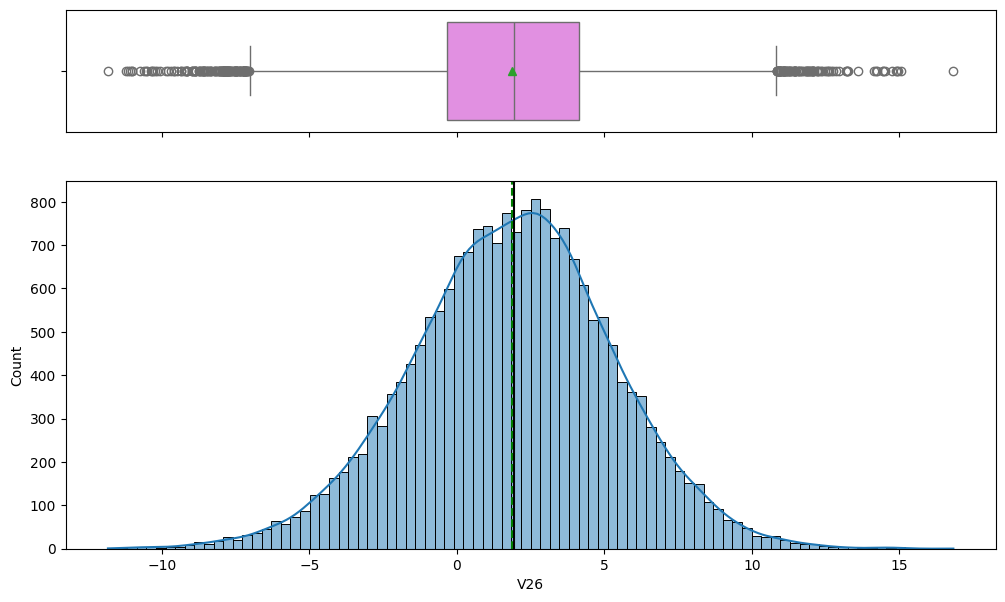

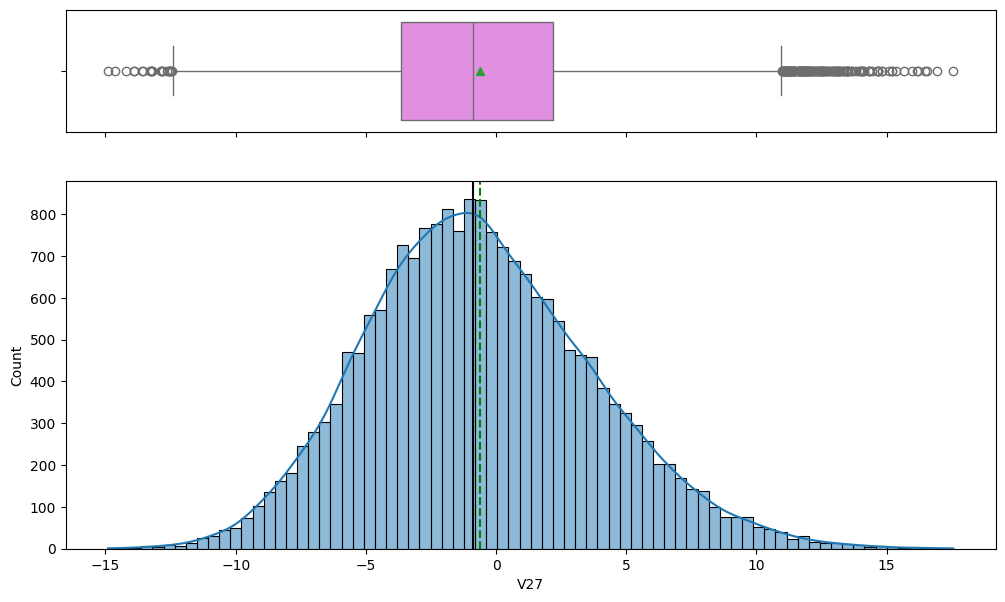

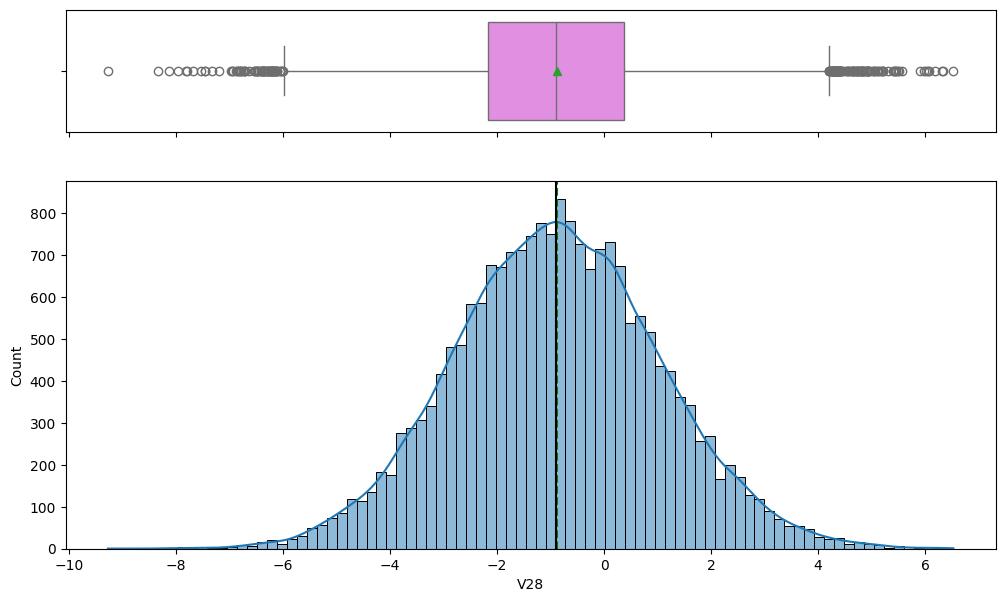

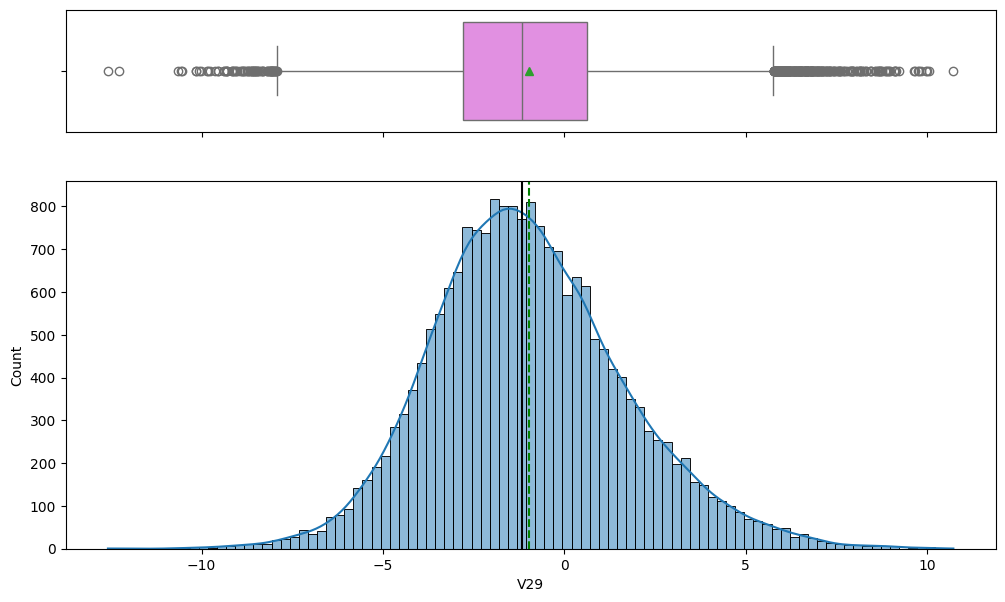

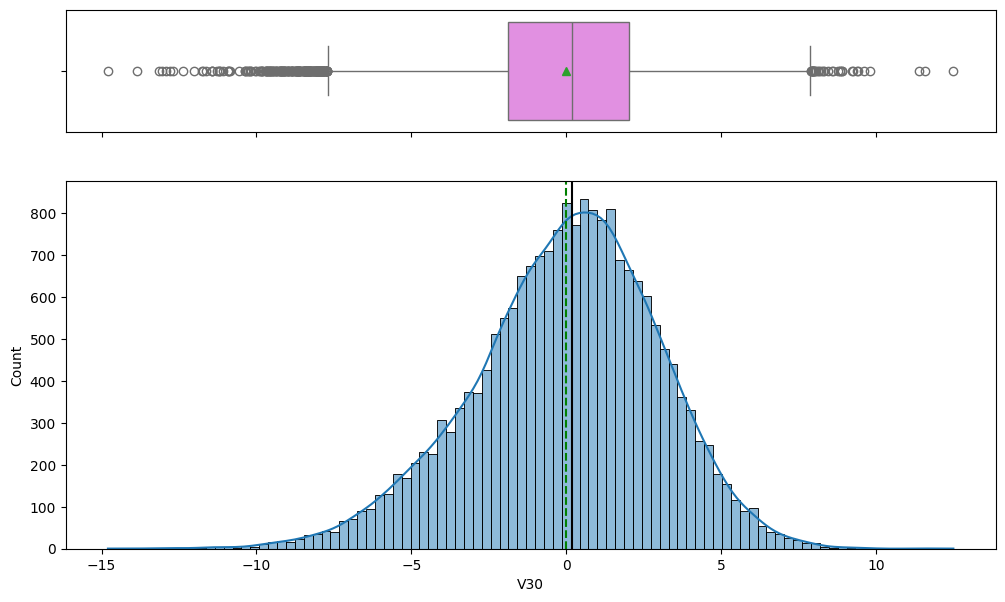

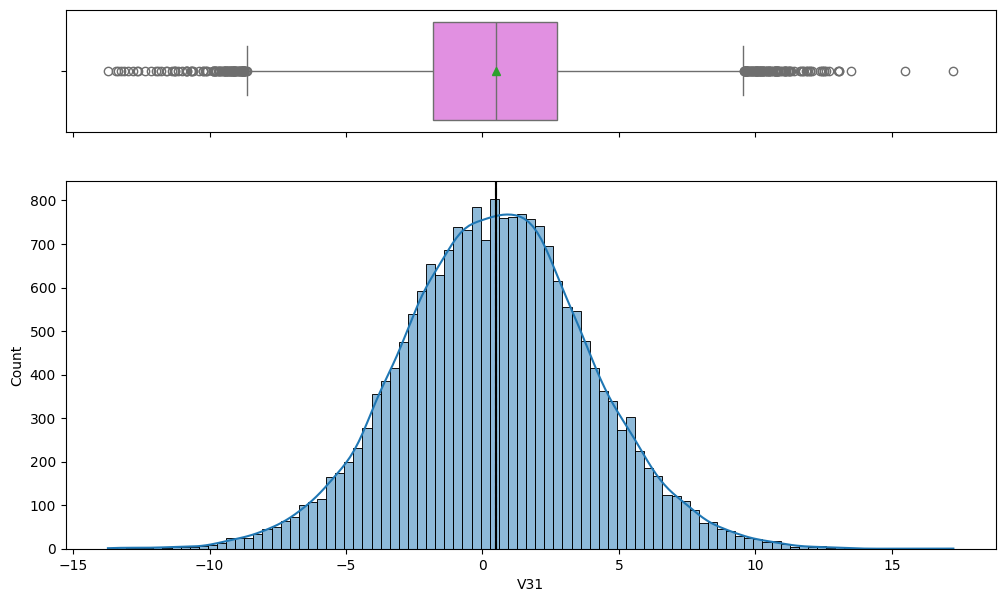

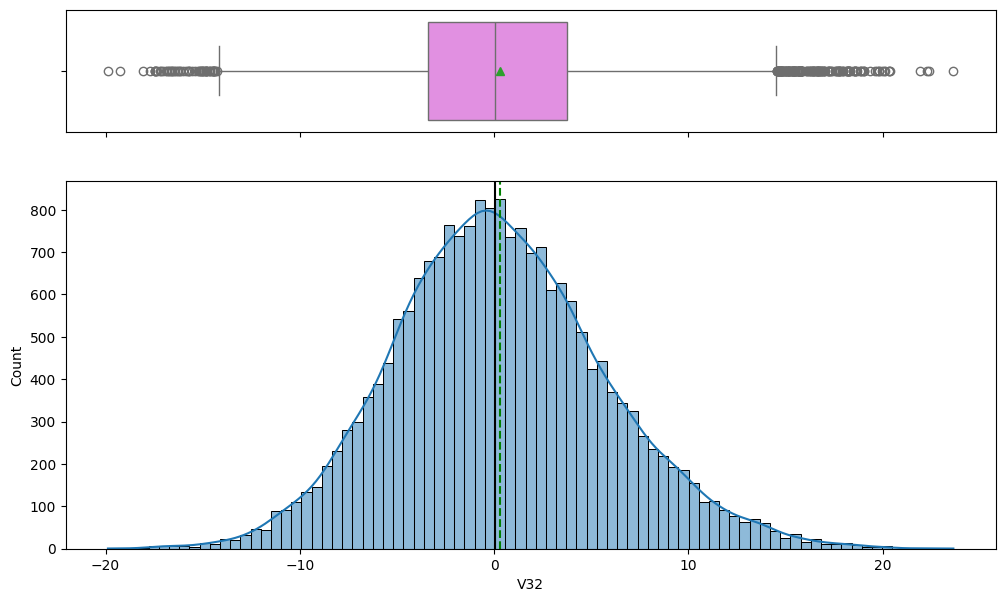

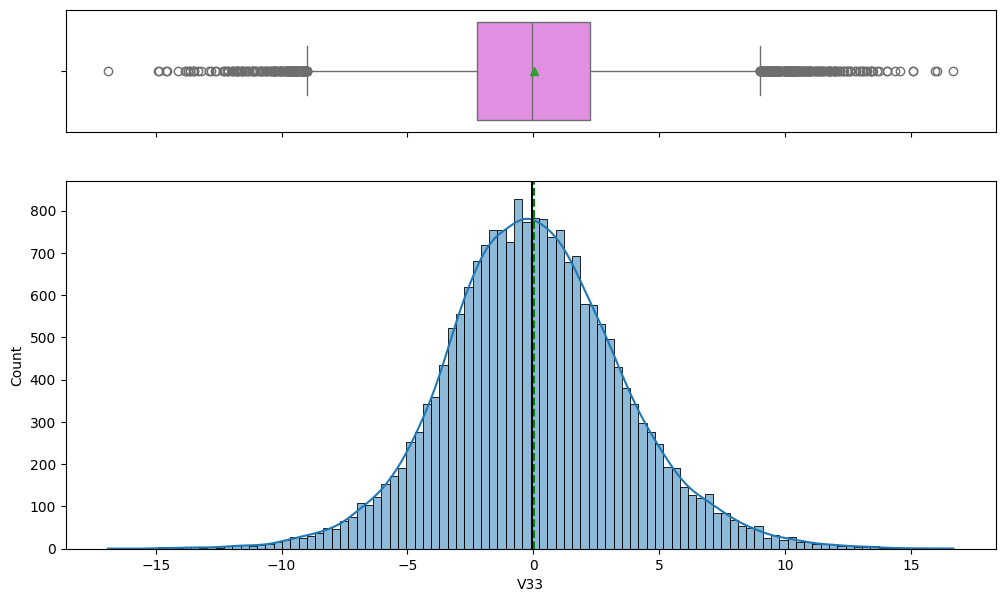

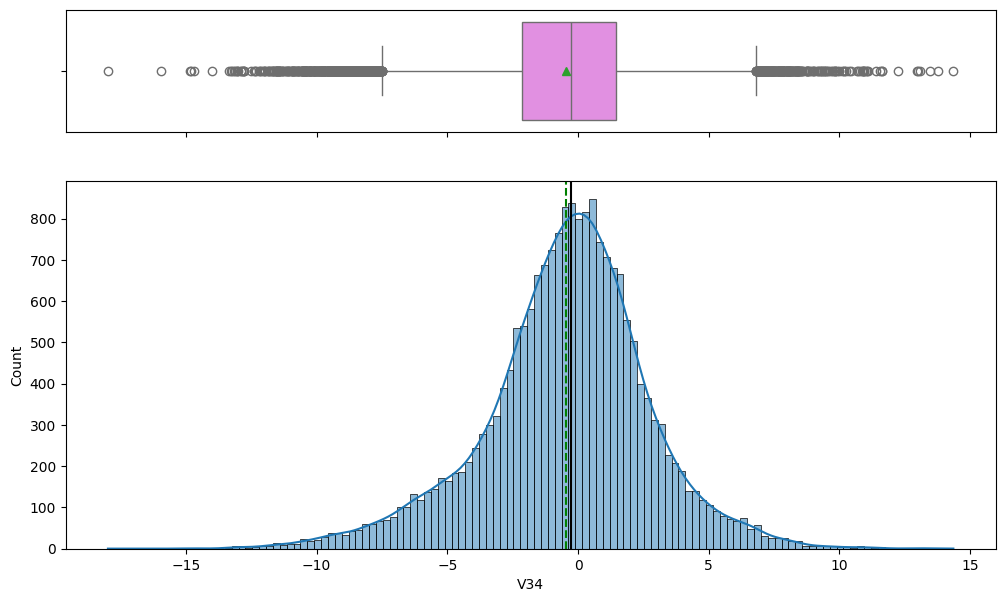

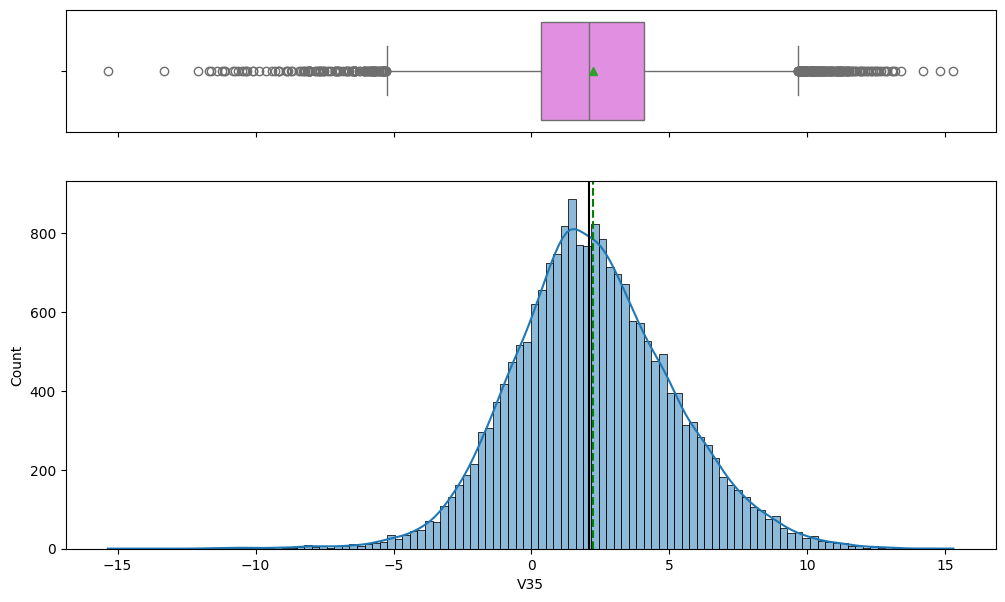

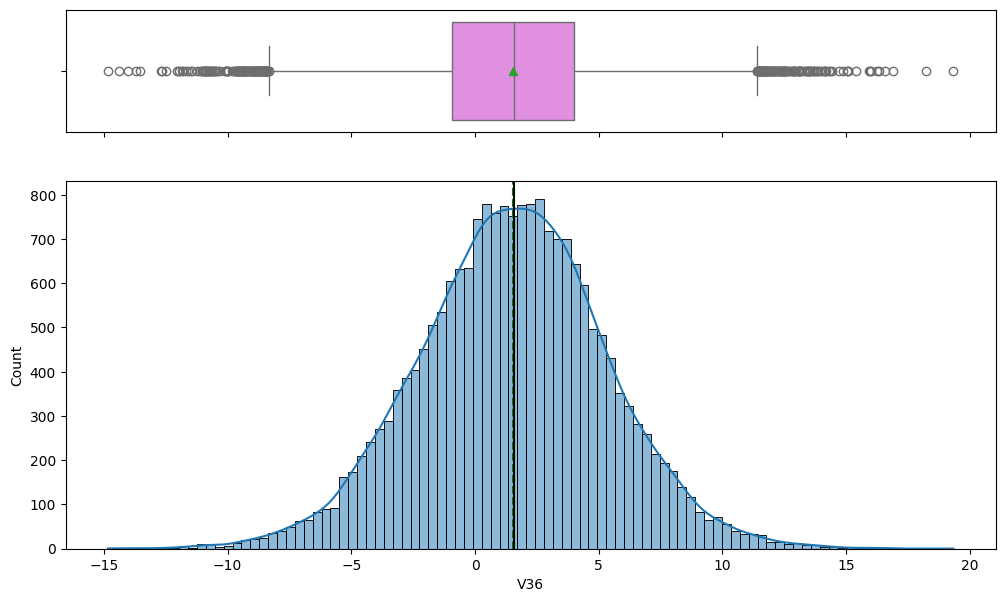

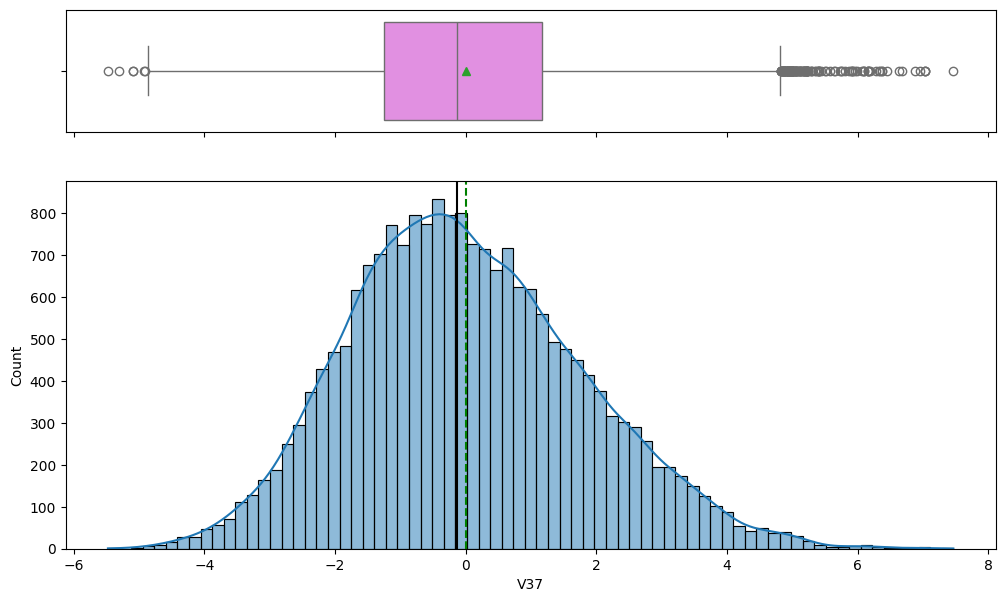

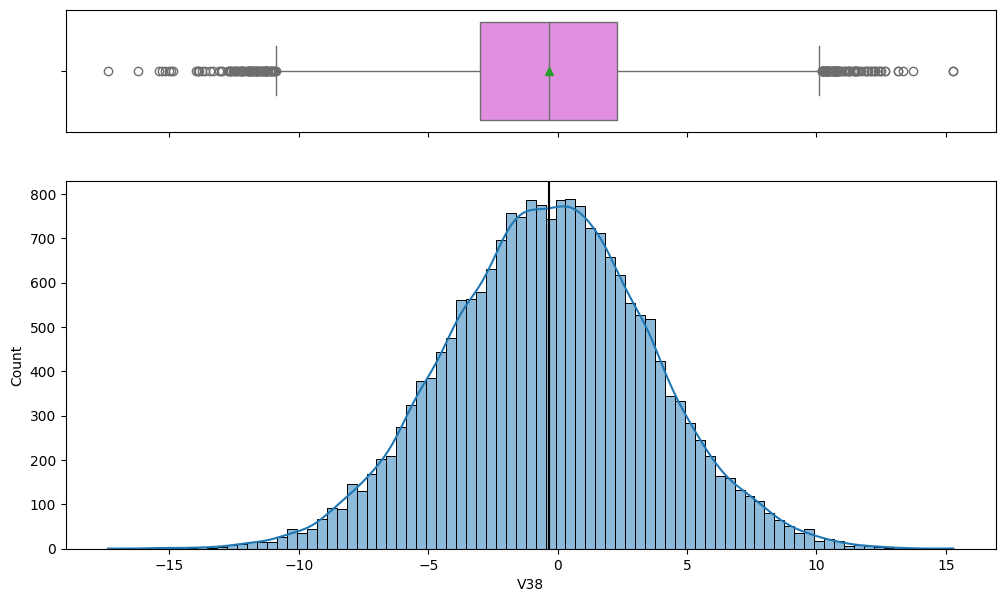

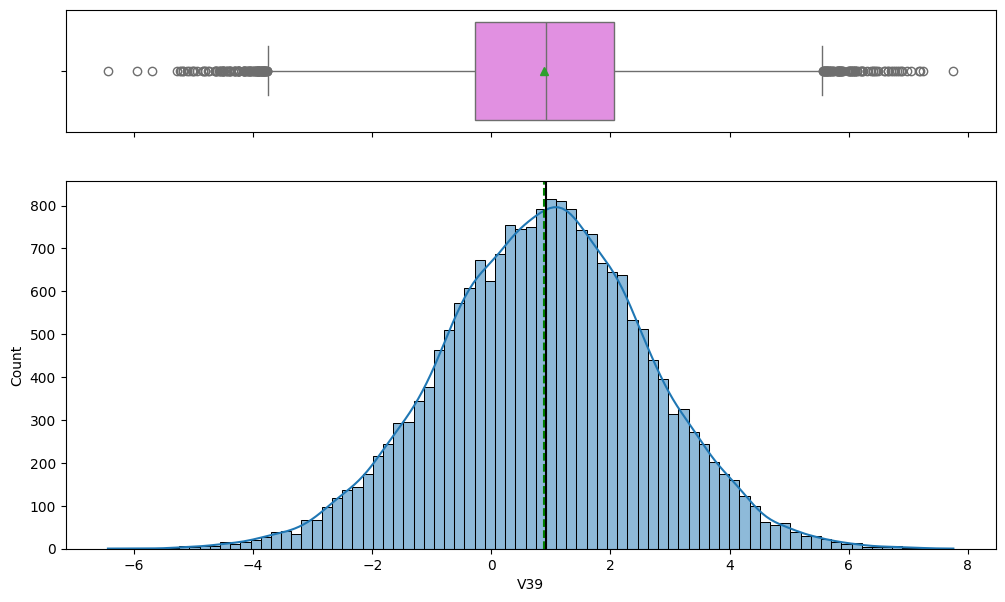

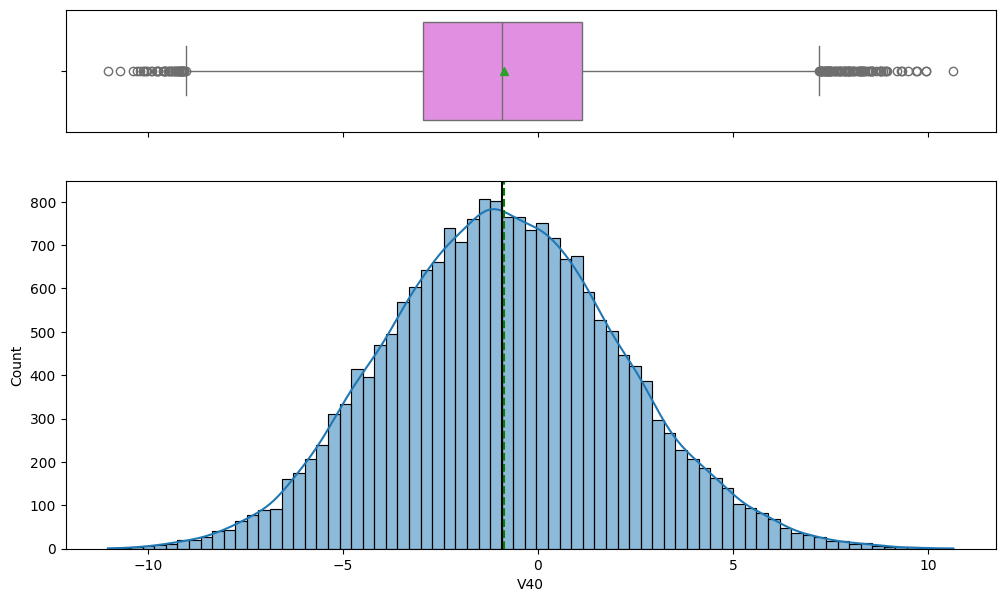

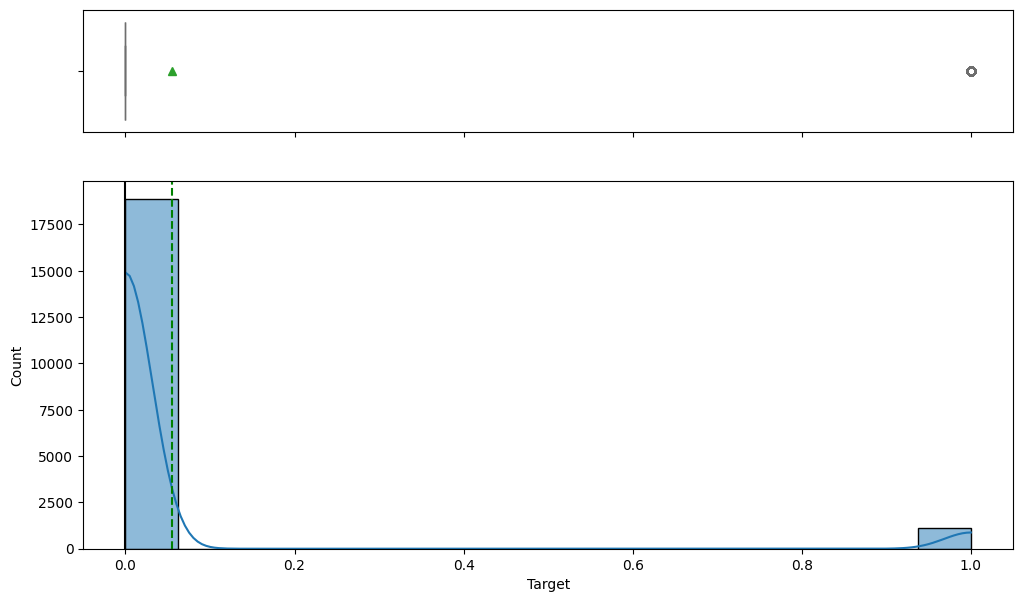

In [17]:
for feature in df.columns:
    histogram_boxplot(df, feature, figsize=(12, 7), kde=True, bins=None)

In [18]:
# Checking the counts for the target variable
df.Target.value_counts()

Target
0    18890
1     1110
Name: count, dtype: int64

* The distribution of all attributes (V1 to V40) is almost symmetrical.
* As observed previously, there are positive and negative values for all predictor variables.
* There are outliers on all predictor variables (V1 to V40), we will not treat them as they are ciphered and are considered true values.
* Most of the sensors detect that the generator is not failing (0). There are a few failures (1), 1110 out of the 20000.

## Data Pre-processing
We will apply transformations after splitting the data to avoid data leaks.
- Feature engineering (not needed since all values are true and numerical)
- Preparing data for modeling
- Missing value treatment
- Outlier detection and treatment (not needed, all values are true)

### Preparing data for modeling

In [19]:
# Defining X (independent) and y (dependent) variables for train set
X = df.drop(['Target'], axis=1)
y = df['Target']

In [20]:
# Splitting train dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y)

# Checking the number of rows and columns in training and validation sets
print(X_train.shape, X_val.shape)

(15000, 40) (5000, 40)


In [21]:
# Defining X (independent) and y (dependent) variables for test set
X_test = df_test.drop(['Target'], axis=1)
y_test = df_test['Target']

# Checking the number of rows and columns in test set
print(X_test.shape)

(5000, 40)


* Training set has 15000 rows while validation and test sets have 5000 rows each.
* All sets have 40 columns corresponding to the independent variables.

### Missing value imputation




* We will use median to impute missing values in V1 and V2.

In [22]:
imputer = SimpleImputer(strategy='median')

# Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_train.columns)

# fit and transform the imputer on test data
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns)

In [23]:
# Checking that there are no missing values in train or test sets
print(X_train.isna().sum())
print("-" * 30)
print(X_val.isna().sum())
print("-" * 30)
print(X_test.isna().sum())

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22

* There are no missing values in the dataset.

## Model Building

### Model evaluation criterion

#### Model can make wrong predictions as:
1. Predicting a generator will not fail but in reality it does.
2. Predicting a generator will fail but it in reality doesn't.

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want **Recall** to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [24]:
# Defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # Predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1

        },
        index=[0],
    )

    return df_perf

In [25]:
# Defining a function to display confusion matrix
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [26]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

We will start by building 7 different models using KFold and cross_val_score. Then, we will tune the best 3 models using GridSearchCV and RandomizedSearchCV.

We are building the following initial models:
* Decision Tree
* Bagging Classifier
* Random Forest
* Logistic Regression
* Gradient Boosting Classifier
* AdaBoost
* XGBoost

In [27]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("Logistic Regression", LogisticRegression(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree: 0.6982829521679532
Bagging: 0.7210807301060529
Random forest: 0.7235192266070268
Logistic Regression: 0.4927566553639709
GBM: 0.7066661857008874
Adaboost: 0.6309140754635308
Xgboost: 0.8100497799581561

Validation Performance:

dtree: 0.7050359712230215
Bagging: 0.7302158273381295
Random forest: 0.7266187050359713
Logistic Regression: 0.48201438848920863
GBM: 0.7230215827338129
Adaboost: 0.6762589928057554
Xgboost: 0.8309352517985612


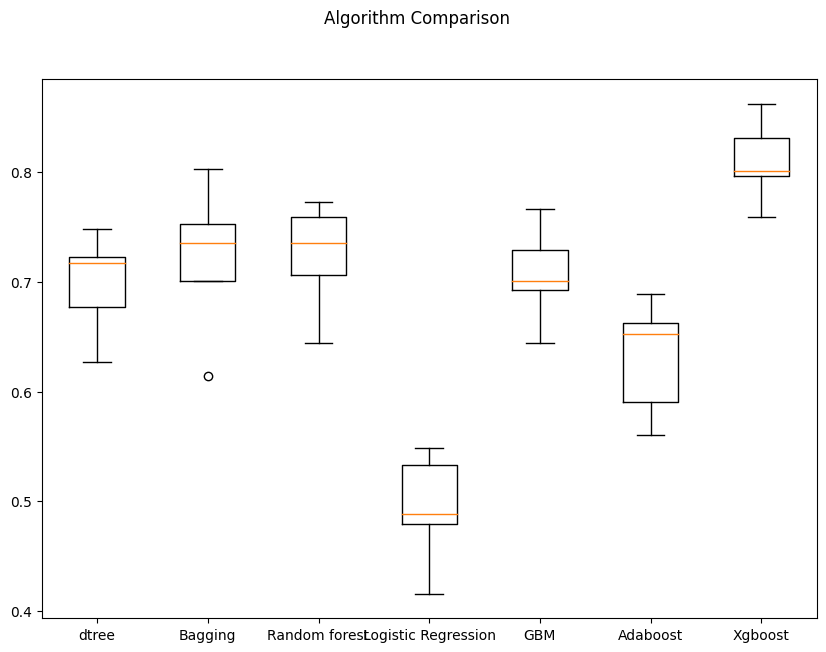

In [28]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10,7))

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

* XGBoost is giving the highest cross-validated recall followed by Bagging and Random Forest.
* Boxplot shows that the performance of these models is also consistent in training and validation sets.
* We will build the same 7 models with oversampled data and check the performance scores.

### Model Building with Oversampled data


In [29]:
print("Before Oversampling, counts of label 'Yes' : {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of label 'No' : {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

print("After Oversampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))


print("After Oversampling, the shape of X_train: {}".format(X_train_over.shape))
print("After Oversampling, the shape of y_train: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label 'Yes' : 832
Before Oversampling, counts of label 'No' : 14168 

After Oversampling, counts of label 'Yes': 14168
After Oversampling, counts of label 'No': 14168 

After Oversampling, the shape of X_train: (28336, 40)
After Oversampling, the shape of y_train: (28336,) 



In [30]:
models_over = []  # Empty list to store all the models

# Appending models into the list
models_over.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_over.append(("Bagging", BaggingClassifier(random_state=1)))
models_over.append(("Random forest", RandomForestClassifier(random_state=1)))
models_over.append(("Logistic Regression", LogisticRegression(random_state=1)))
models_over.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_over.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_over.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results_over = []  # Empty list to store all model's CV scores
names_over = []  # Empty list to store name of the models

# Loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models_over:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results_over.append(cv_result)
    names_over.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree: 0.9720494245534969
Bagging: 0.9762141471581656
Random forest: 0.9839075260047615
Logistic Regression: 0.883963699328486
GBM: 0.9256068151319724
Adaboost: 0.8978689011775473
Xgboost: 0.9891305241357218

Validation Performance:

dtree: 0.7769784172661871
Bagging: 0.8345323741007195
Random forest: 0.8489208633093526
Logistic Regression: 0.8489208633093526
GBM: 0.8776978417266187
Adaboost: 0.8561151079136691
Xgboost: 0.8669064748201439


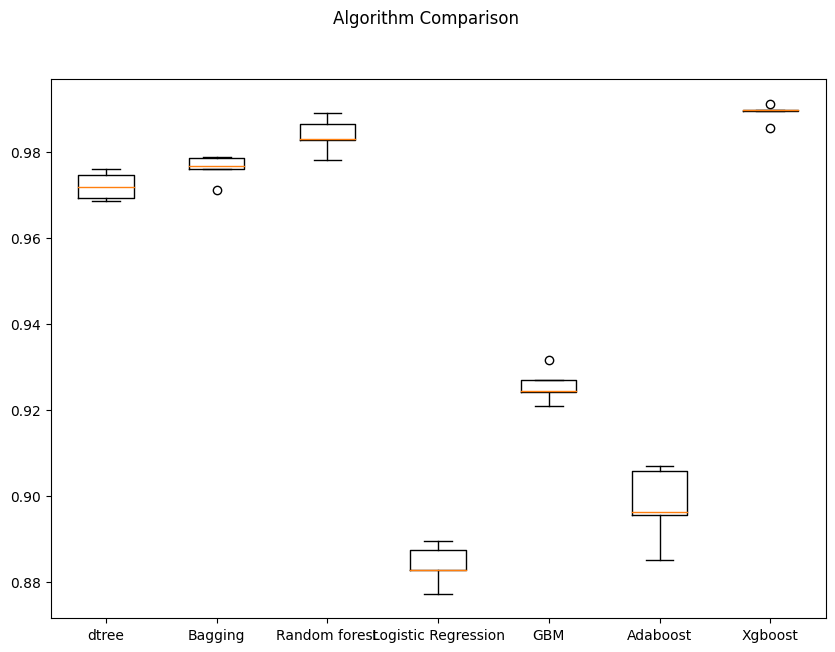

In [31]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10,7))

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(results_over)
ax.set_xticklabels(names_over)

plt.show()

* XGBoost is giving the best cross-validated recall followed by Random Forest and Bagging.
* The performance of these models decreases significantly in validation set. Gradient boosting and AdaBoost show a smaller decrease in validation set.
* All of these models are performing better overall than the models with original data.
* We will build all seven models with undersampled data.

### Model Building with Undersampled data

In [32]:
print("Before Undersampling, counts of label 'Yes' : {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label 'No' : {} \n".format(sum(y_train == 0)))

# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print("After Undersampling, counts of label 'Yes': {}".format(sum(y_train_under == 1)))
print("After Undersampling, counts of label 'No': {} \n".format(sum(y_train_under == 0)))

print("After Undersampling, the shape of X_train: {}".format(X_train_under.shape))
print("After Undersampling, the shape of y_train: {} \n".format(y_train_under.shape))

Before Undersampling, counts of label 'Yes' : 832
Before Undersampling, counts of label 'No' : 14168 

After Undersampling, counts of label 'Yes': 832
After Undersampling, counts of label 'No': 832 

After Undersampling, the shape of X_train: (1664, 40)
After Undersampling, the shape of y_train: (1664,) 



In [33]:
models_under = []  # Empty list to store all the models

# Appending models into the list
models_under.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_under.append(("Bagging", BaggingClassifier(random_state=1)))
models_under.append(("Random forest", RandomForestClassifier(random_state=1)))
models_under.append(("Logistic Regression", LogisticRegression(random_state=1)))
models_under.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_under.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_under.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results_under = []  # Empty list to store all model's CV scores
names_under = []  # Empty list to store name of the models

# Loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models_under:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_under, y=y_train_under, scoring=scorer, cv=kfold
    )
    results_under.append(cv_result)
    names_under.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models_under:
    model.fit(X_train_under, y_train_under)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree: 0.8617776495202367
Bagging: 0.8641945025611427
Random forest: 0.9038669648654498
Logistic Regression: 0.8726138085275232
GBM: 0.8990621167303946
Adaboost: 0.8666113556020489
Xgboost: 0.9014717552846114

Validation Performance:

dtree: 0.841726618705036
Bagging: 0.8705035971223022
Random forest: 0.8920863309352518
Logistic Regression: 0.8525179856115108
GBM: 0.8884892086330936
Adaboost: 0.8489208633093526
Xgboost: 0.89568345323741


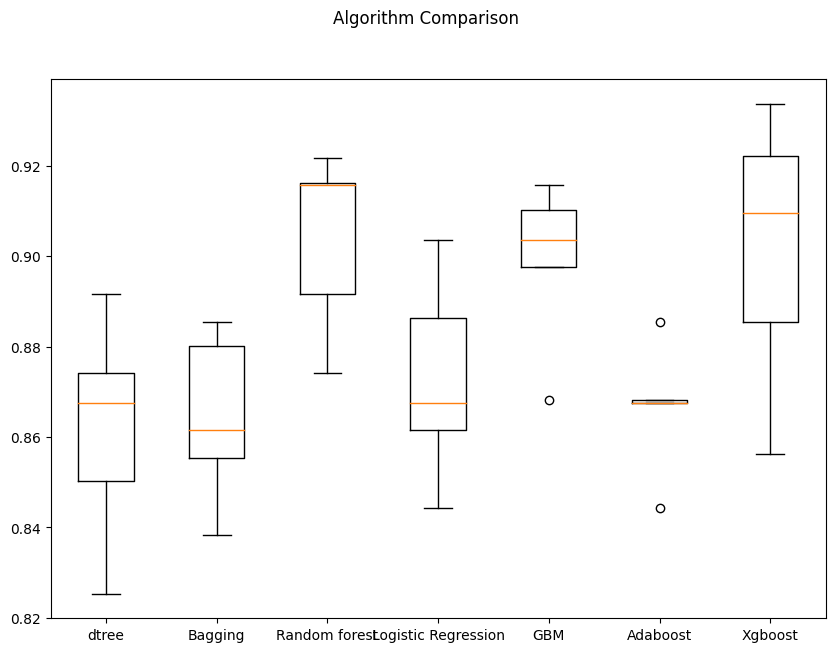

In [34]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10,7))

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(results_under)
ax.set_xticklabels(names_under)

plt.show()

* Random Forest is giving the best cross-validated recall. Followed by XGBoost and Gradient Boosting.
* The boxplot shows that XGBoost gives a higher recall score but with a lower median than Random Forest.
* We will tune the best performing models.


## Hyperparameter Tuning

We will tune the following models with oversampled data: Gradient Boosting, AdaBoost, and XGBoost.

The following models with undersampled data are tuned: Random Forest and XGBoost.

To tune the models, we will use RandomizedSearchCV as it is computationally less expensive. Then we will compare the performance of all models and select our final one.

### Tuning Gradient Boosting using oversampled data

In [37]:
# Defining model
gbm_random = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7] }

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=gbm_random, param_distributions=param_grid, scoring=scorer, n_iter=50, n_jobs = -1, cv=5, random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9723322092856124:


In [38]:
# Creating model with best parameters
tuned_gbm_random = GradientBoostingClassifier(
    max_features=0.5,
    random_state=1,
    learning_rate=0.2,
    n_estimators=125,
    subsample=0.7
)

tuned_gbm_random.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=1, subsample=0.7)

In [39]:
# Checking metrics for train set with random search
gbm_random_train = model_performance_classification_sklearn(tuned_gbm_random, X_train_over, y_train_over)
gbm_random_train

,Accuracy,Recall,Precision,F1
0,0.973,0.960,0.986,0.973


In [40]:
# Checking metrics for validation set with random search
gbm_random_val = model_performance_classification_sklearn(tuned_gbm_random, X_val, y_val)
gbm_random_val

,Accuracy,Recall,Precision,F1
0,0.975,0.878,0.724,0.793


* By looking at recall scores in training and validation data, tuned gradient boosting model is overfitting the data.
* The validation recall has remained almost the same (0.878) as compared to cross-validated recall (0.877).

### Tuning AdaBoost with oversampled data

In [41]:
# Defining model
abm_random = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in GridSearchCV
param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=abm_random, param_distributions=param_grid, n_jobs = -1, n_iter=50, scoring=scorer, cv=5, random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_, randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9714853746337214:


In [42]:
# Creating a new pipeline with best parameters
tuned_abm_random = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.2,
    random_state=1,
    base_estimator=DecisionTreeClassifier(max_depth=3, random_state=1),
)

# Fit the model on training data
tuned_abm_random.fit(X_train_over, y_train_over)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.2, n_estimators=200, random_state=1)

In [43]:
# Calculating metrics on train set with random search
abm_random_train= model_performance_classification_sklearn(tuned_abm_random, X_train_over, y_train_over)
abm_random_train

,Accuracy,Recall,Precision,F1
0,0.992,0.988,0.995,0.992


In [44]:
# Looking at the metrics on validation set
abm_random_val= model_performance_classification_sklearn(tuned_abm_random, X_val, y_val)
abm_random_val

,Accuracy,Recall,Precision,F1
0,0.979,0.853,0.790,0.820


* The model is still overfitting. There is a big difference in the training and validation recall.
* Cross-validation recall in tuned model has increased significantly as compared to initial model.

### Tuning Random Forest with undersampled data

In [45]:
# Defining model
rf_random = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomizedSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=rf_random, param_distributions=param_grid, scoring=scorer, cv=5, n_jobs = -1, n_iter=50, random_state=1)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_under, y_train_under)

print("Best Parameters:{} \nScore: {}".format(randomized_cv.best_params_, randomized_cv.best_score_))

Best Parameters:{'n_estimators': 300, 'min_samples_leaf': 2, 'max_samples': 0.5, 'max_features': 'sqrt'} 
Score: 0.8990116153235697


In [46]:
# Creating a new pipeline with best parameters
tuned_rf_random = RandomForestClassifier(
    n_estimators=300,
    random_state=1,
    max_features='sqrt',
    max_samples=0.5,
    min_samples_leaf=2
)

# Fit the model on training data
tuned_rf_random.fit(X_train_under, y_train_under)

RandomForestClassifier(max_samples=0.5, min_samples_leaf=2, n_estimators=300,
                       random_state=1)

In [47]:
# Calculating metrics on train set
rf_random_train= model_performance_classification_sklearn(tuned_rf_random, X_train_under, y_train_under)
rf_random_train

,Accuracy,Recall,Precision,F1
0,0.961,0.933,0.989,0.960


In [48]:
# Calculating metrics on validation set
rf_random_val= model_performance_classification_sklearn(tuned_rf_random, X_val, y_val)
rf_random_val

,Accuracy,Recall,Precision,F1
0,0.938,0.885,0.468,0.612


* Random Forest model is not overfitting as much as previous tuned models.
* There isn't a lot of improvement after tuning the model.

### Tuning XGBoost with undersampled data

In [49]:
# Defining model
xgb_random = XGBClassifier(random_state=1,eval_metric='logloss')

# Parameter grid to pass in RandomizedSearchCV
param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling RandomizedSearchCV
random_cv = RandomizedSearchCV(estimator=xgb_random, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

# Fitting parameters in RandomizedSearchCV
random_cv.fit(X_train_under, y_train_under)

print("Best parameters are {} with CV score={}:" .format(random_cv.best_params_, random_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.9290599523843879:


In [50]:
# Building model with best parameters
tuned_xgb_random = XGBClassifier(
    random_state=1,
    n_estimators=200,
    scale_pos_weight=10,
    subsample=0.9,
    learning_rate=0.1,
    gamma=5,
    eval_metric="logloss"
)

# Fit the model on training data
tuned_xgb_random.fit(X_train_under, y_train_under)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [51]:
# Calculating metrics on train set
xgb_random_train= model_performance_classification_sklearn(tuned_xgb_random, X_train_under, y_train_under)
xgb_random_train

,Accuracy,Recall,Precision,F1
0,0.979,1.000,0.960,0.979


In [52]:
# Calculating metrics on validation set
xgb_random_val= model_performance_classification_sklearn(tuned_xgb_random, X_val, y_val)
xgb_random_val

,Accuracy,Recall,Precision,F1
0,0.832,0.921,0.239,0.379


* XGBoost on undersampled data is the best performing model so far.
* The model is able to predict 92% of the failures.

### Tuning XGBoost with oversampled data

In [53]:
# Defining model
xgb_random1 = XGBClassifier(random_state=1,eval_metric='logloss')

# Parameter grid to pass in RandomizedSearchCV
param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling RandomizedSearchCV
random_cv1 = RandomizedSearchCV(estimator=xgb_random, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

# Fitting parameters in RandomizedSearchCV
random_cv1.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(random_cv1.best_params_, random_cv1.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 150, 'learning_rate': 0.1, 'gamma': 0} with CV score=0.9960475154078072:


In [54]:
# Building model with best parameters
tuned_xgb_random1 = XGBClassifier(
    random_state=1,
    n_estimators=150,
    scale_pos_weight=10,
    subsample=0.9,
    learning_rate=0.1,
    gamma=0,
    eval_metric="logloss",
)

# Fit the model on training data
tuned_xgb_random1.fit(X_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [55]:
# Calculating metrics on train set
xgb_random1_train= model_performance_classification_sklearn(tuned_xgb_random1, X_train_over, y_train_over)
xgb_random1_train

,Accuracy,Recall,Precision,F1
0,0.994,1.000,0.988,0.994


In [56]:
# Calculating metrics on validation set
xgb_random1_val= model_performance_classification_sklearn(tuned_xgb_random1, X_val, y_val)
xgb_random1_val

,Accuracy,Recall,Precision,F1
0,0.967,0.892,0.648,0.750


* Model is overfitting the data as recall score decrease significantly for validation set.

## Model performance comparison and choosing the final model

### Model performances on training and validation sets

In [63]:
# Training performance comparison
models_train_comp_df = pd.concat(
    [
        gbm_random_train.T,
        abm_random_train.T,
        rf_random_train.T,
        xgb_random_train.T,
        xgb_random1_train.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Gradient Boosting Tuned",
    "AdaBoost Tuned",
    "Random Forest Tuned",
    "XGBoost Undersampled Tuned",
    "XGBoost Oversampled Tuned"
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Gradient Boosting Tuned,AdaBoost Tuned,Random Forest Tuned,XGBoost Undersampled Tuned,XGBoost Oversampled Tuned
Accuracy,0.973,0.992,0.961,0.979,0.994
Recall,0.960,0.988,0.933,1.000,1.000
Precision,0.986,0.995,0.989,0.960,0.988
F1,0.973,0.992,0.960,0.979,0.994


In [64]:
# Validation performance comparison
models_val_comp_df = pd.concat(
    [
        gbm_random_val.T,
        abm_random_val.T,
        rf_random_val.T,
        xgb_random_val.T,
        xgb_random1_val.T
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Gradient Boosting Tuned",
    "AdaBoost Tuned",
    "Random Forest Tuned",
    "XGBoost Undersampled Tuned",
    "XGBoost Oversampled Tuned"
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Gradient Boosting Tuned,AdaBoost Tuned,Random Forest Tuned,XGBoost Undersampled Tuned,XGBoost Oversampled Tuned
Accuracy,0.975,0.979,0.938,0.832,0.967
Recall,0.878,0.853,0.885,0.921,0.892
Precision,0.724,0.790,0.468,0.239,0.648
F1,0.793,0.820,0.612,0.379,0.750


* XGBoost with undersampled data is the best performing model in regards to recall with ~0.921 on validation set.
* We'll check the model performance on the test set.

### Test set final performance

In [65]:
# Calculating metrics on test set (XGBoost with undersampled data)
xgb_random_test = model_performance_classification_sklearn(tuned_xgb_random, X_test, y_test)
print('Test performance:')
xgb_random_test

Test performance:


,Accuracy,Recall,Precision,F1
0,0.834,0.890,0.239,0.376


* The performance on test data is overfitting slightly.
* XGBoost with undersampled data is giving a recall score of 0.897.
* Let's take a look at the confusion matrix for XGBoost model.

### Confusion matrix for XGBoost with undersampled data

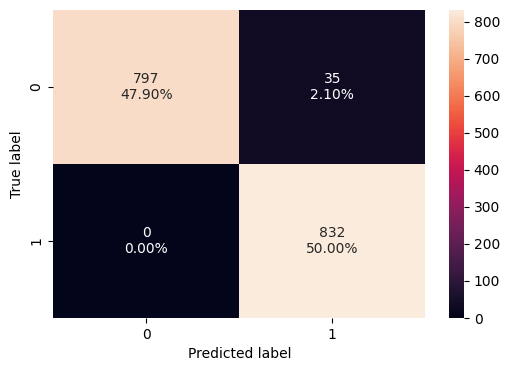

In [66]:
# Printing the confusion matrix on training data
confusion_matrix_sklearn(tuned_xgb_random, X_train_under, y_train_under)

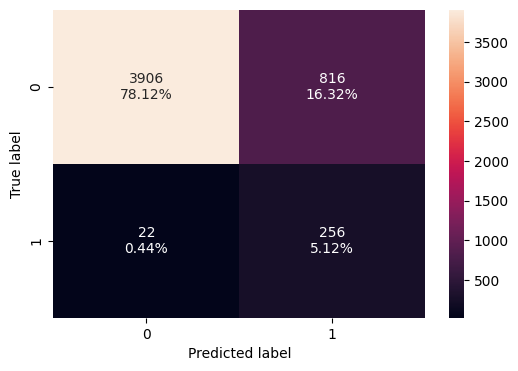

In [67]:
# Printing the confusion matrix on validation data
confusion_matrix_sklearn(tuned_xgb_random, X_val, y_val)

* Model is generalizing well on data. It is giving a generalized performance.
* Model can identify most false negatives.
* We'll check the important features for prediction using this model.

### Feature importance

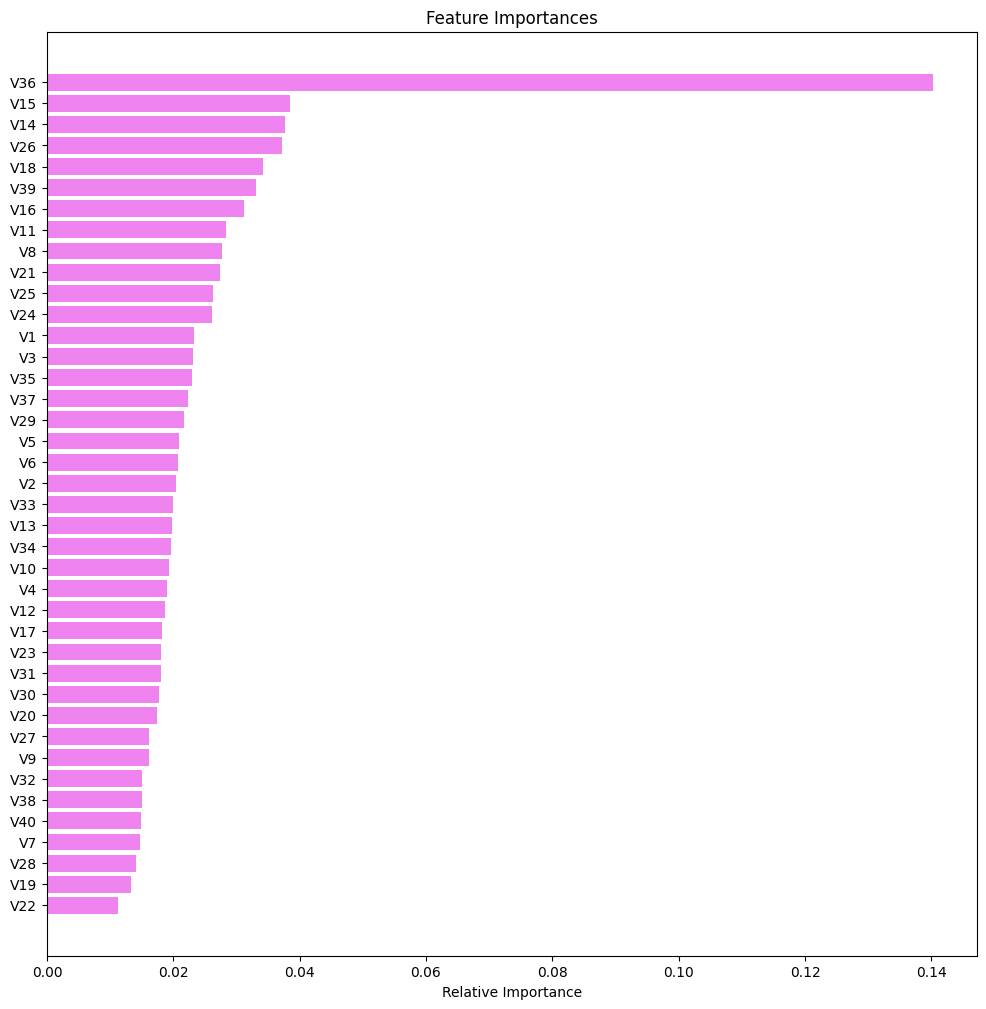

In [68]:
feature_names = X.columns
importances = tuned_xgb_random.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

* V36 is the most important feature.
* Other features with similar importance are V15, V14, and V26.

## Pipelines to build the final model


Now that we have the final model, we'll use pipelines to put the model into production. Using pipelines help standardize the model building.

Since we already know the best performing model, we will not divide the data into 3 parts.

In [69]:
# Creating pipeline with best parameters
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
                        (
                            "XGB",
                            XGBClassifier(
                                random_state=1,
                                n_estimators=200,
                                scale_pos_weight=10,
                                subsample=0.9,
                                learning_rate=0.1,
                                gamma=5,
                                eval_metric="logloss"
                                )
                        )
    ]
)

In [70]:
# Splitting the train dataset into dependent and independent variables
X_pipe = df.drop(['Target'], axis=1)
Y_pipe = df['Target']

In [71]:
# Splitting the test data into X and Y variables
X_test_pipe = df_test.drop(['Target'], axis=1)
Y_test_pipe = df_test['Target']

In [74]:
# Imputting missing values before undersampling data
imputer = SimpleImputer(strategy='median')

# Fit and transform the train data
X_pipe = imputer.fit_transform(X_pipe)

In [75]:
# Undersampling data on training set
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_pipe_under, Y_pipe_under = rus.fit_resample(X_pipe, Y_pipe)

In [76]:
# Fitting the model on training data
pipe.fit(X_pipe_under, Y_pipe_under)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=1, ...))])

In [78]:
# Checking performance on test set
pipe_test = model_performance_classification_sklearn(pipe, X_test_pipe, Y_test_pipe)
print("Final Model performance on Test Dataset:")
pipe_test

Final Model performance on Test Dataset:


,Accuracy,Recall,Precision,F1
0,0.838,0.890,0.244,0.383


* Model is able to predict most generator failures.
* XGBoost tuned with undersampled data has a recall score of 0.89.
* Accuracy score with this model is good and generalizes well on data.
* Precision score is low with ~0.24, which will result in generator inspections due to high false positives.

# Business Insights and Conclusions

* We tried to maximize recall as the cost of false negatives is high. A false negative would result in replacing the generator, which is costlier than repairs and inspections.
* The final model is able to predict 89% of the failures. The model also has high accuracy that will help the business identify repairs.
* Although precision is low, the cost of inspections is less than repairs and replacements.
* The company should look at predictor V36 as it's the most important feature in identifying failures.
* Other important sensors to consider are V14, V15, and V26.
* The distribution of data in all variables is almost symmetrical. We considered all values to be true as predictors are ciphered.
* Some data was missing and values were inputted using median to avoid disrupting the distribution.

***